# Generate a Mock Dataset

Generate a simulated TF dataset as follows:

* Merge the iron photometric + spectroscopic catalogs with the SGA2020 catalog.
* Apply all photometric corrections used in the TF analysis.
* Cross-match with one of the BGS mocks.
* Apply photometric and morphological cuts used in the PV survey for late-type galaxies.
* Generate mock rotational velocities by sampling from the data.
* Generate mock TFR distances.

Here, we fit the TFR in bins of $z$ (as our "clusters").

In [1]:
import os
import shutil
import h5py
import fitsio
import pickle
import healpy as hp
import pandas as pd
import numpy as np
import scipy as sp

from itertools import groupby

from csaps import csaps
from scipy.interpolate import PchipInterpolator, UnivariateSpline
from scipy.stats import binned_statistic
from scipy.odr import ODR, Model, RealData
from scipy.spatial import KDTree

#- Global file path for PV analysis.
#  Set to the NERSC folder /global/cfs/cdirs/desi/science/td/pv by default.
#  Set it to something else if working offline.
pvpath = '/global/cfs/cdirs/desi/science/td/pv'
mockpath = os.path.join(pvpath, 'mocks')
tfmockpath = os.path.join(mockpath, 'TF_mocks')

from corner import corner

#- Path to TF_mocks: code for Blanton's k-corrections.
import sys
sys.path.append(tfmockpath)
import TF_photoCorrect as tfpc
# from line_fits import hyperfit_line_multi

# from hyperfit.linfit import LinFit
sys.path.append('/global/u1/k/kadglass/DESI_SGA/TF/')
from line_fits import hyperfit_line_multi

from astropy import units as u
from astropy.io import fits
from astropy.table import Table
from astropy.cosmology import Planck18, FlatLambdaCDM, units
from astropy.coordinates import SkyCoord, Distance

from tqdm import tqdm
from glob import glob

import matplotlib as mpl
import matplotlib.colors as colors
import matplotlib.pyplot as plt

import logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

In [2]:
def profile_histogram(x, y, xbins, yerr=None, weights=None, median=False, weighted=False):
    """Compute a profile histogram from scattered data.
    
    Parameters
    ----------
    x : list or ndarray
        Ordinates (independent variable).
    y : list or ndarray
        Coordinates (dependent variable).
    xbins : list or ndarray
        Bin edges for the independent variable.
    yerr : list or ndarray
        Uncertainties on the dependent variable. Assumed independent.
    weights : list or ndarray
        If not None (and weighted=True), will use this instead of yerr to weight 
        the summary statistics.
    median : bool
        If true, compute median as central value; else, the (weighted) mean.
    weighted : bool
        Weight the summary statistics, either by the uncertainty in y or the 
        provided weights.
        
    Returns
    -------
    N : ndarray
        Unweighted counts per bin.
    h : ndarray
        Summary statistic (mean or median) of independent variable per bin.
    e : ndarray
        Uncertainty on the summary statistic per bin.
    """
    
    N = binned_statistic(x, y, bins=xbins, statistic='count').statistic

    if weighted:
        if (yerr is None) and (weights is None):
            raise ValueError('need to define either yerr or weights if using weighted fit.')

        if weights is None:
            # weight based on yerr
            w = 1/yerr**2
        else:
            w = weights
        W, H, E = binned_statistic(x, [w, w*y, w*y**2], bins=xbins, statistic='sum').statistic
        h = H/W
        e = 1/np.sqrt(W)
    else:
        mean, mean2 = binned_statistic(x, [y, y**2], bins=xbins, statistic='mean').statistic
        h = mean
        e = np.sqrt((mean2 - mean**2) / (N - 1))

    if median:
        h = binned_statistic(x, y, bins=xbins, statistic='median').statistic
    
    return N, h, e

## Iron Data + SGA Catalog

Follow the procedure used in FP mock generation: read in iron data relevant for the TFR for cross-matching to the BGS mocks, producing a simulated set with realistic galaxy observables.

Here we merge the fullsweep and iron specprod catalogs to reproduce cuts when cross-matching with the mocks.

As a final step, get any missing SGA data directly from the SGA 2020 catalog.

In [3]:
#- Read in the iron fullsweep and specprod catalogs.
sw_keys = ['targetid', 'survey', 'program', 'healpix', 'target_ra', 'target_dec',
           'z', 'zerr', 'zwarn', 'inbasiccuts', 'has_corrupt_phot',
           'mag_g', 'mag_r', 'mag_z',
           'morphtype', 'sersic', 'BA_ratio',
           'circ_radius', 'circ_radius_err', 'uncor_radius', 'SGA_id', 'radius_SB25']

ironsweep = os.path.join(pvpath, 'redshift_data/Y1/iron_fullsweep_catalogue_z012.csv')
iron = pd.read_csv(ironsweep, usecols=sw_keys)

#- Read in the spectroscopic production table generated by Caitlin Ross.
sp_keys = ['targetid', 'survey', 'program', 'healpix',
           'mag_err_g', 'mag_err_r', 'mag_err_z', 
           'deltachi2']

ironspec = os.path.join(pvpath, 'redshift_data/Y1/specprod_iron_healpix_z015.csv')
ironsp = pd.read_csv(ironspec, usecols=sp_keys)

#- Cross-match the catalogs.
iron = pd.merge(iron, ironsp, 
                left_on=['targetid', 'survey', 'program', 'healpix'],
                right_on=['targetid', 'survey', 'program', 'healpix'], how='inner')

#- Object selection from the spectro pipeline:
#  1. Valid SGA ID, which implicitly enforces a size selection.
#  2. Delta-chi2 > 25.
#  3. No redrock warnings.
select = (iron['SGA_id'] > 0) & \
         (iron['deltachi2'] >= 25) & \
         (iron['zwarn'] == 0)

iron = iron.drop(iron[~select].index)

#- Read the SGA catalog and match on SGA_ID.
#  This is needed to access R_26 and other quantities at the mag 26 isophote.
sgafile = '/global/cfs/cdirs/cosmo/data/sga/2020/SGA-2020.fits'
sgacat = Table.read(sgafile, 'ELLIPSE')
sgacat.rename_column('SGA_ID', 'SGA_id')
sgacat.rename_column('RA', 'SGA_ra')
sgacat.rename_column('DEC', 'SGA_dec')
sgacat = sgacat['SGA_ra', 'SGA_dec', 'SGA_id', 'D26', 'G_MAG_SB26', 'G_MAG_SB26_ERR', 'R_MAG_SB26', 'R_MAG_SB26_ERR', 'Z_MAG_SB26', 'Z_MAG_SB26_ERR'].to_pandas()
sgacat = sgacat.drop(sgacat[sgacat['R_MAG_SB26'] < 0].index)

iron = pd.merge(iron, sgacat, how='inner', on=['SGA_id'])

In [4]:
#- Drop NaN
iron = iron.dropna()
iron

survey program  healpix           targetid  target_dec   target_ra  \
0         sv1  bright    34723  39627082556248187  -30.586432   58.890261   
1         sv1  bright    34725  39627082589804885  -30.509964   61.244826   
2         sv1  bright    34703  39627082593998226  -30.408004   61.518464   
3         sv1  bright    34729  39627087765574578  -30.251105   58.278362   
4         sv1  bright    34729  39627087773962063  -30.188369   58.780902   
...       ...     ...      ...                ...         ...         ...   
102514   main    dark     7975   2852649649045504   72.895711  131.867353   
102515   main    dark     7973   2852649653239808   72.926464  133.218536   
102516   main    dark     8034   2852673590132736   76.634771  140.593982   
102517    sv3  bright    11604  39633456283519525   66.170195  266.658931   
102518    sv3    dark    11604  39633456283519525   66.170195  266.658931   

               z          zerr  zwarn morphtype  ...  mag_err_r      SGA_ra  \
0       0.093327  1.755050e-05      0       SER  ...   0.000430   58.890261   
1       0.058229  3.289745e-06      0       SER  ...   0.000833   61.244826   
2       0.059050  2.278493e-06      0       SER  ...   0.000355   61.518464   
3       0.081022  1.363088e-05      0       SER  ...   0.001176   58.278362   
4       0.096937  1.941603e-05      0       SER  ...   0.000785   58.780902   
...          ...           ...    ...       ...  ...        ...         ...   
102514  0.011291  7.328162e-06      0       DEV  ...   0.000785  131.867353   
102515  0.012603  7.566643e-07      0       DEV  ...   0.000462  133.218536   
102516  0.076971  4.815062e-06      0       SER  ...   0.001131  140.593982   
102517  0.117068  1.531648e-05      0       SER  ...   0.001742  266.658931   
102518  0.117098  8.208770e-06      0       SER  ...   0.001742  266.658931   

          SGA_dec       D26  G_MAG_SB26  G_MAG_SB26_ERR  R_MAG_SB26  \
0      -30.586432  0.575315   17.063408        0.034668   16.134380   
1      -30.509964  0.398020   17.159575        0.005541   16.691721   
2      -30.408004  0.998481   16.092411        0.024773   15.328482   
3      -30.251105  0.427528   18.176348        0.028036   17.460354   
4      -30.188369  0.648811   17.540487        0.039971   16.529564   
...           ...       ...         ...             ...         ...   
102514  72.895711  0.841495   16.188450        0.005690   15.252360   
102515  72.926464  1.141312   15.233910        0.016896   14.147840   
102516  76.634771  0.515602   16.521830        0.005591   15.891319   
102517  66.170195  0.686332   16.746572        0.019684   16.290340   
102518  66.170195  0.686332   16.746572        0.019684   16.290340   

        R_MAG_SB26_ERR  Z_MAG_SB26  Z_MAG_SB26_ERR  
0             0.038069   15.478448        0.039409  
1             0.005926   16.403215        0.006768  
2             0.026500   14.777832        0.026026  
3             0.029271   16.949606        0.031180  
4             0.041773   15.713690        0.042567  
...                ...         ...             ...  
102514        0.006012   14.736343        0.008489  
102515        0.015995   13.483636        0.021117  
102516        0.005790   15.526414        0.006989  
102517        0.016576   16.699310        0.030471  
102518        0.016576   16.699310        0.030471  

[93971 rows x 35 columns]

### Keep only Galaxy Centers

The iron catalog may include some off-axis measurements of SGA galaxies that pass the spectroscopic cuts. Remove them with a cone-angle cut, comparing the SGA centers (from Tractor) to the target RA, Dec in DESI. The cut is

$$
\frac{\angle(\mathbf{r}_\mathrm{SGA}, \mathbf{r}_\mathrm{fiber})}{D_{26}/2} < 0.1
$$

See details in Kelly's [SGA selection notebook for iron](https://github.com/DESI-UR/DESI_SGA/blob/master/TF/Y1/iron_rot_vel.ipynb).

Note that requiring a nonzero $m_{r,\mathrm{SB_{26}}}$ may remove all spectra not measured on galaxy centers, making this cut redundant.

In [5]:
coords_sga = SkyCoord(ra=iron['SGA_ra'], dec=iron['SGA_dec'], unit='degree')
coords_iron = SkyCoord(ra=iron['target_ra'], dec=iron['target_dec'], unit='degree')
sep2d = coords_iron.separation(coords_sga)
select = (2*sep2d.to_value('arcmin') / iron['D26']) < 0.1

iron = iron.drop(iron[~select].index)

In [6]:
iron

survey program  healpix           targetid  target_dec   target_ra  \
0         sv1  bright    34723  39627082556248187  -30.586432   58.890261   
1         sv1  bright    34725  39627082589804885  -30.509964   61.244826   
2         sv1  bright    34703  39627082593998226  -30.408004   61.518464   
3         sv1  bright    34729  39627087765574578  -30.251105   58.278362   
4         sv1  bright    34729  39627087773962063  -30.188369   58.780902   
...       ...     ...      ...                ...         ...         ...   
102514   main    dark     7975   2852649649045504   72.895711  131.867353   
102515   main    dark     7973   2852649653239808   72.926464  133.218536   
102516   main    dark     8034   2852673590132736   76.634771  140.593982   
102517    sv3  bright    11604  39633456283519525   66.170195  266.658931   
102518    sv3    dark    11604  39633456283519525   66.170195  266.658931   

               z          zerr  zwarn morphtype  ...  mag_err_r      SGA_ra  \
0       0.093327  1.755050e-05      0       SER  ...   0.000430   58.890261   
1       0.058229  3.289745e-06      0       SER  ...   0.000833   61.244826   
2       0.059050  2.278493e-06      0       SER  ...   0.000355   61.518464   
3       0.081022  1.363088e-05      0       SER  ...   0.001176   58.278362   
4       0.096937  1.941603e-05      0       SER  ...   0.000785   58.780902   
...          ...           ...    ...       ...  ...        ...         ...   
102514  0.011291  7.328162e-06      0       DEV  ...   0.000785  131.867353   
102515  0.012603  7.566643e-07      0       DEV  ...   0.000462  133.218536   
102516  0.076971  4.815062e-06      0       SER  ...   0.001131  140.593982   
102517  0.117068  1.531648e-05      0       SER  ...   0.001742  266.658931   
102518  0.117098  8.208770e-06      0       SER  ...   0.001742  266.658931   

          SGA_dec       D26  G_MAG_SB26  G_MAG_SB26_ERR  R_MAG_SB26  \
0      -30.586432  0.575315   17.063408        0.034668   16.134380   
1      -30.509964  0.398020   17.159575        0.005541   16.691721   
2      -30.408004  0.998481   16.092411        0.024773   15.328482   
3      -30.251105  0.427528   18.176348        0.028036   17.460354   
4      -30.188369  0.648811   17.540487        0.039971   16.529564   
...           ...       ...         ...             ...         ...   
102514  72.895711  0.841495   16.188450        0.005690   15.252360   
102515  72.926464  1.141312   15.233910        0.016896   14.147840   
102516  76.634771  0.515602   16.521830        0.005591   15.891319   
102517  66.170195  0.686332   16.746572        0.019684   16.290340   
102518  66.170195  0.686332   16.746572        0.019684   16.290340   

        R_MAG_SB26_ERR  Z_MAG_SB26  Z_MAG_SB26_ERR  
0             0.038069   15.478448        0.039409  
1             0.005926   16.403215        0.006768  
2             0.026500   14.777832        0.026026  
3             0.029271   16.949606        0.031180  
4             0.041773   15.713690        0.042567  
...                ...         ...             ...  
102514        0.006012   14.736343        0.008489  
102515        0.015995   13.483636        0.021117  
102516        0.005790   15.526414        0.006989  
102517        0.016576   16.699310        0.030471  
102518        0.016576   16.699310        0.030471  

[93971 rows x 35 columns]

## Apply Dust and K-corrections

There are four photometric corrections that need to be applied.

1. N vs. S imaging catalog photometric systematics.
2. $k$-corrections to $z=0.1$.
3. Global Milky Way dust corrections using the maps from Zhou+, 2024.
4. Per-galaxy internal dust corrections based on the galaxies' inclination angles.

The corrections, applied to the $r$-band magnitudes, are summed as

$$
A_\mathrm{sys} + A_k + A_\mathrm{MW} + A_\mathrm{dust}
$$

### Imaging Systematics

In [7]:
#- Apply imaging survey systematics: compute photometric system (N or S)
#  Note that we need the RA,Dec of the *data*, not the mocks, because the corrections
#  are applied to the observed magnitudes from SGA (MAG_R_SB26, etc.).
c = SkyCoord(iron['target_ra'], iron['target_dec'], unit='degree')
isnorth = (c.galactic.b > 0) & (iron['target_dec'] > 32.375)
iron['photsys'] = 'S'
iron.loc[isnorth, 'photsys'] = 'N'

#- Adjust northern photometry to DECaLS
Asys, Asys_err = tfpc.BASS_corr(iron['photsys'])

### K Correction

In [8]:
#- This is based on the kcorrect package by Blanton (https://kcorrect.readthedocs.io/)
#  Note that we need the RA,Dec of the *data*, not the mocks, because the corrections
#  are applied to the observed magnitudes from SGA (MAG_R_SB26, etc.).
select = iron['z'] > 0

kc = tfpc.k_corr(iron['z'][select], 
                [iron['G_MAG_SB26'][select],     iron['R_MAG_SB26'][select],     iron['Z_MAG_SB26'][select]], 
                [iron['G_MAG_SB26_ERR'][select], iron['R_MAG_SB26_ERR'][select], iron['Z_MAG_SB26_ERR'][select]], 
                z_corr=0.1)

Ak = np.zeros((len(iron), 3))
Ak[select] = kc

### MW Dust Correction

In [9]:
#- Compute MW dust corrections
#  Note that we need the RA,Dec of the *data*, not the mocks, because the corrections
#  are applied to the observed magnitudes from SGA (MAG_R_SB26, etc.).
dustmap = '/global/cfs/cdirs/desi/public/papers/mws/desi_dust/y2/v1/maps/desi_dust_gr_512.fits'
ebv = Table.read(dustmap)
Adust, Adust_err = tfpc.MW_dust(iron['target_ra'].values, iron['target_dec'].values, ebv)

#- Mask out NaNs
for i, band in enumerate('grz'):
    isnan_gal = np.isnan(Adust[i])
    if np.any(isnan_gal):
        logging.info(f'Removing NaN for MW dust correction, band {band}')
        Adust[i][isnan_gal] = 0
        Adust_err[i][isnan_gal] = 0

/global/cfs/cdirs/desi/science/td/pv/mocks/TF_mocks/TF_photoCorrect.py:90: UserWarning: Warning: converting a masked element to nan.
  EBV_err[i] = ebv_map['EBV_GR_ERR'][i_ebv]


### Apply MW, K-Correction, and Imaging Systematics Corrections Prior to Internal Dust Correction

In [10]:
#- Apply MW dust, k-corrections, and photometric systematic corrections to the data.
for i, band in enumerate('GRZ'):
    iron[f'{band}_MAG_SB26_tmp'] = iron[f'{band}_MAG_SB26'] - Adust[i] + Asys + Ak[:,i]
    iron[f'{band}_MAG_SB26_ERR_tmp'] = np.sqrt(iron[f'{band}_MAG_SB26_ERR']**2 + Adust_err[i]**2 + Asys_err**2)

### Internal Dust Correction 

Correct m_r for the internal galactic dust, assuming that as we look through higher inclinations we're viewing the galaxy through its dust lanes. Details in [this notebook by Kelly](https://github.com/DESI-UR/DESI_SGA/blob/master/TF/Y1/TF_iron_internal-dustCorr.ipynb).

Best fit:     [-1.37475514  0.75256222]
uncertainty:  [0.08632504 0.04738354]


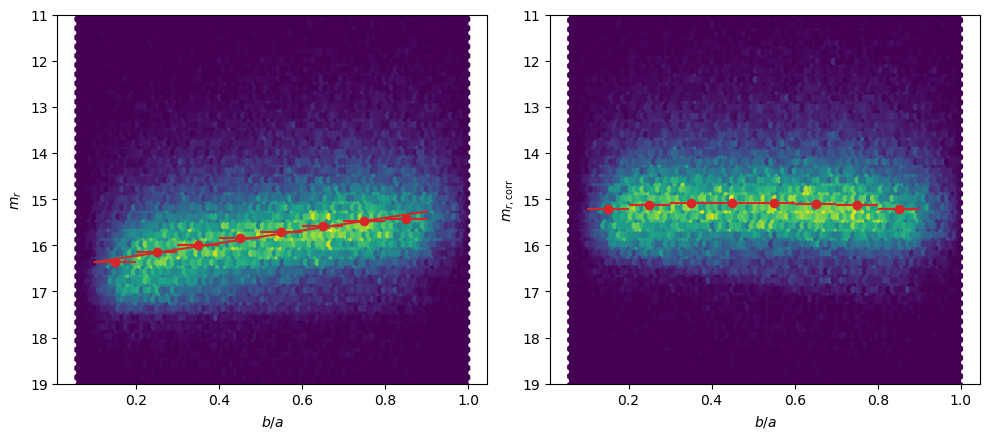

In [11]:
#- Kelly applies an empirical fit to the internal dust in each galaxy. Steps:
#   1. Apply "known" corrections (k-correction, MW dust).
#   2. Fit m_r_corr (corrected) vs spiral b/a
#   3. Zero out this linear dependence.

#- Set up a binned data set and perform the fit
ba_bins = np.arange(0.1,1,0.1)
ba = 0.5*(ba_bins[1:] + ba_bins[:-1])
ba_err = 0.5*np.diff(ba_bins)
m_r_median = np.median(iron['R_MAG_SB26_tmp'])
m_r, _, _ = binned_statistic(iron['BA_ratio'], iron['R_MAG_SB26_tmp'], statistic='median', bins=ba_bins)
n_bin, _, _ = binned_statistic(iron['BA_ratio'], iron['R_MAG_SB26_tmp'], statistic='count', bins=ba_bins)
m_r_err, _, _ = binned_statistic(iron['BA_ratio'], iron['R_MAG_SB26_tmp'], statistic='std', bins=ba_bins)
m_r_err /= np.sqrt(n_bin)

linear_fit = lambda coeff, x: coeff[0]*x + coeff[1]
model = Model(linear_fit)
data = RealData(ba, m_r - m_r_median, sx=ba_err, sy=m_r_err)
odr = ODR(data, model, beta0=[1, 1])

result = odr.run()
coeff = result.beta
coeff_err = result.sd_beta
print('Best fit:    ', coeff)
print('uncertainty: ', coeff_err)

fig, axes = plt.subplots(1,2, figsize=(10,4.5), tight_layout=True, sharex=True)#, sharey=True)
ax = axes[0]
# ax.scatter(iron['BA_ratio'], iron['R_MAG_SB26_tmp'], alpha=0.01)
ax.hexbin(iron['BA_ratio'], iron['R_MAG_SB26_tmp'])
ax.errorbar(ba, m_r, xerr=ba_err, yerr=m_r_err, fmt='o', color='tab:red')
ax.plot(ba_bins, coeff[0]*ba_bins + coeff[1] + m_r_median, color='tab:red')
ax.set(ylim=(19, 11),
       ylabel='$m_{r}$',
       xlabel='$b/a$');

#- Compute the internal dust correction
A_int, A_int_err = tfpc.internal_dust(iron['BA_ratio'].values, coeff, coeff_err)

ax = axes[1]
# ax.scatter(iron['BA_ratio'], iron['R_MAG_SB26_tmp'] - A_int, alpha=0.01)
ax.hexbin(iron['BA_ratio'], iron['R_MAG_SB26_tmp'] - A_int)
m_r, _, _ = binned_statistic(iron['BA_ratio'], iron['R_MAG_SB26_tmp'] - A_int, statistic='median', bins=ba_bins)
ax.errorbar(ba, m_r, xerr=ba_err, yerr=m_r_err, fmt='o', color='tab:red')
ax.set(ylim=(19, 11),
       ylabel='$m_{r,\mathrm{corr}}$',
       xlabel='$b/a$')

# fig.savefig('tfr_mock_internal_dust_correction.png', dpi=150);

#- Update the r-band magnitudes
iron['R_MAG_SB26_CORR'] = iron['R_MAG_SB26_tmp'] - A_int
iron['R_MAG_SB26_ERR_CORR'] = np.sqrt(iron['R_MAG_SB26_ERR_tmp']**2 + A_int_err**2)

## BGS Mock Catalog

Read in one of the mock catalog files and cross-match to iron.

In [12]:
#- There are 25 BGS mocks and (usually) 27 realizations per mock.
#  Pick one, it doesn't matter which.
mockfiles = sorted(glob(os.path.join(pvpath, 'mocks/BGS_base/v0.5/iron/BGS_PV_AbacusSummit_base*.hdf5')))
n_mock = len(mockfiles)
# mockfile = mockfiles[0]
# mockfile = mockfiles[np.random.randint(n_mock)]
mockfile = os.path.join(pvpath, 'mocks/BGS_base/v0.5/iron/BGS_PV_AbacusSummit_base_c000_ph002_r009_z0.11.dat.hdf5')

print(f'Picked mock file {os.path.basename(mockfile)}.')

Picked mock file BGS_PV_AbacusSummit_base_c000_ph002_r009_z0.11.dat.hdf5.


In [13]:
#- Fill the catalog as a dictionary and convert to a Pandas table.
#  Here we follow the I/O from the FP generator (thanks Cullan).
mock = {}
with h5py.File(mockfile, 'r') as f:
    for key in f.keys():
        if key == 'vel':
            #- Pack the galaxy velocities into labeled vx, vy, vz
            mock['vx'] = f['vel'][:,0]
            mock['vy'] = f['vel'][:,1]
            mock['vz'] = f['vel'][:,2]
        else:
            mock[key] = f[key][()]

        # convert strings to unicode
        if key == 'survey' or key == 'program':
            mock[key] = mock[key].astype('U')

    #- Convert to a pandas table
    mock = pd.DataFrame.from_dict(mock)

    #- Merge with iron on 4 keywords
    mock = mock.merge(iron, how='inner', on=['targetid', 'survey', 'program', 'healpix'])

In [14]:
mock.keys()

Index(['Y1_COMP', 'Y3_COMP', 'Y5', 'abs_mag', 'app_mag', 'col', 'col_obs',
       'dec', 'halo_mass', 'healpix', 'is_cen', 'is_res', 'program', 'ra',
       'survey', 'targetid', 'vx', 'vy', 'vz', 'zcos', 'zobs', 'target_dec',
       'target_ra', 'z', 'zerr', 'zwarn', 'morphtype', 'sersic', 'mag_g',
       'mag_r', 'mag_z', 'uncor_radius', 'BA_ratio', 'circ_radius',
       'circ_radius_err', 'SGA_id', 'radius_SB25', 'inbasiccuts',
       'has_corrupt_phot', 'deltachi2', 'mag_err_g', 'mag_err_z', 'mag_err_r',
       'SGA_ra', 'SGA_dec', 'D26', 'G_MAG_SB26', 'G_MAG_SB26_ERR',
       'R_MAG_SB26', 'R_MAG_SB26_ERR', 'Z_MAG_SB26', 'Z_MAG_SB26_ERR',
       'photsys', 'G_MAG_SB26_tmp', 'G_MAG_SB26_ERR_tmp', 'R_MAG_SB26_tmp',
       'R_MAG_SB26_ERR_tmp', 'Z_MAG_SB26_tmp', 'Z_MAG_SB26_ERR_tmp',
       'R_MAG_SB26_CORR', 'R_MAG_SB26_ERR_CORR'],
      dtype='object')

In [15]:
mock

Y1_COMP   Y3_COMP    Y5    abs_mag    app_mag       col   col_obs  \
0       0.993377  0.993377  True -21.091625  16.568933  0.933861  0.958352   
1       0.967949  0.967949  True -21.471888  16.197651  0.978291  1.005045   
2       0.000000  0.977778  True -20.380521  17.264551  0.259534  0.270146   
3       0.000000  1.000000  True -20.046582  17.613633  0.596316  0.610325   
4       1.000000  0.987421  True -21.413115  16.232377  0.642484  0.656188   
...          ...       ...   ...        ...        ...       ...       ...   
458767  0.785714  1.000000  True -20.802694  16.773885  1.007147  1.023148   
458768  0.000000  1.000000  True -21.002222  16.595622  0.990817  1.009188   
458769  0.910828  0.955414  True -20.820322  16.792020  0.845970  0.862280   
458770  0.000000  1.000000  True -21.062711  16.569868  0.982307  1.004684   
458771  0.000000  0.780142  True -21.557647  16.111717  1.011686  1.038882   

             dec     halo_mass  healpix  ...  Z_MAG_SB26_ERR  photsys  \
0      -0.084735  4.542962e+12    28590  ...        0.025350        S   
1      -3.467677  1.490699e+13    11259  ...        0.012585        N   
2      -4.775817  9.448685e+11    10994  ...        0.014216        N   
3       6.470891  6.601425e+11     4610  ...        0.036829        S   
4       3.328613  3.973510e+12     7444  ...        0.010554        N   
...          ...           ...      ...  ...             ...      ...   
458767 -3.039632  1.405281e+14    10200  ...        0.034800        N   
458768 -4.188371  5.652549e+13     8267  ...        0.016627        S   
458769 -4.283950  5.062217e+13     6577  ...        0.042253        N   
458770 -4.188017  2.965369e+13    19199  ...        0.037996        S   
458771 -6.748777  3.966339e+13    25531  ...        0.013396        S   

       G_MAG_SB26_tmp  G_MAG_SB26_ERR_tmp R_MAG_SB26_tmp  R_MAG_SB26_ERR_tmp  \
0           17.362385            0.052419      16.436303            0.043166   
1           17.176222            0.043804      16.173951            0.033884   
2           17.635426            0.051539      17.385348            0.038261   
3           17.768168            0.037786      17.197481            0.034723   
4           16.912318            0.046570      16.270518            0.035227   
...               ...                 ...            ...                 ...   
458767      17.922622            0.037531      16.912982            0.034587   
458768      17.305825            0.056723      16.352243            0.039631   
458769      17.494725            0.061216      16.577124            0.048398   
458770      17.238480            0.039506      16.278959            0.038371   
458771      17.045383            0.032928      16.025221            0.024078   

        Z_MAG_SB26_tmp  Z_MAG_SB26_ERR_tmp  R_MAG_SB26_CORR  \
0            15.813310            0.030833        15.913690   
1            15.629424            0.027718        16.108498   
2            17.400670            0.030246        16.674622   
3            16.725228            0.037660        16.202025   
4            15.841328            0.027522        15.956156   
...                ...                 ...              ...   
458767       16.242732            0.041321        16.277332   
458768       15.587948            0.026107        15.534835   
458769       15.885234            0.049792        15.471922   
458770       15.592459            0.039094        15.232990   
458771       15.330357            0.017762        15.912114   

        R_MAG_SB26_ERR_CORR  
0                  0.054224  
1                  0.034133  
2                  0.058784  
3                  0.071505  
4                  0.040380  
...                     ...  
458767             0.052815  
458768             0.064847  
458769             0.084609  
458770             0.076067  
458771             0.025104  

[458772 rows x 61 columns]

### Apply TF Selection Cuts

Here apply the late-type galaxy cuts defined in *Target Selection for the DESI Peculiar Velocity Survey*, C. Saulder+, MNRAS 525:1106, 2023. Note that several cuts are the complement of the early-type cuts for the FP sample.

In [16]:
mock_selection = {
    'basic cuts' : 0,
    'z < 0.1' : 0,
    'b/a < cos(25°)' : 0,
    'morphtype' : 0,
    'NaN' : 0
}

#- Apply target selection
print(f'Size of cross-matched iron+mock catalog ..{len(mock):.>20d}')

#- Drop data that doesn't pass the photometric cuts
select = (mock['inbasiccuts'] == 0) | (mock['has_corrupt_phot'] == 1)
mock = mock.drop(mock[select].index)
mock_selection['basic cuts'] = len(mock)
print(f'Size after photometric cuts .........{len(mock):.>20d}')

#- Redshift range cut: remove?
select = mock['zobs'] <= 0.105
mock = mock[select]
mock_selection['z < 0.1'] = len(mock)
print(f'Redshift selection: z < 0.1 {len(mock):.>29d}')

#- B/A ratio cut:
select = mock['BA_ratio'] < np.cos(np.radians(25))
mock = mock[select]
mock_selection['b/a < cos(25°)'] = len(mock)
print(f'Ratio b/a < cos(25 deg) .............{len(mock):.>20d}')

#- Morphology cuts:
select = (mock['morphtype'] == 'EXP') | ((mock['morphtype'] == 'SER') & (mock['sersic'] <= 2))
mock = mock[select]
mock_selection['morphtype'] = len(mock)
print(f'Morphology cuts: ....................{len(mock):.>20d}')

#- Drop any rows with NaN
mock = mock.dropna()
mock_selection['NaN'] = len(mock)
print(f'Drop NaN ............................{len(mock):.>20d}')

Size of cross-matched iron+mock catalog ................458772
Size after photometric cuts .......................458614
Redshift selection: z < 0.1 .......................448706
Ratio b/a < cos(25 deg) ...........................433441
Morphology cuts: ..................................234992
Drop NaN ..........................................201214


/tmp/ipykernel_411141/1003090540.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(names, rotation=45, ha='right')


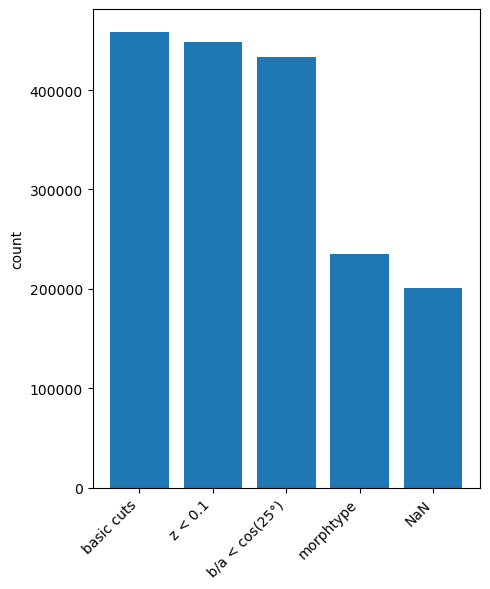

In [17]:
names = list(mock_selection.keys())
values = list(mock_selection.values())

fig, ax = plt.subplots(1, 1, figsize=(5,6), tight_layout=True)
bars = ax.bar(names, values)
ax.set_xticklabels(names, rotation=45, ha='right')
# ax.bar_label(bars, fmt='%d')
ax.set(ylabel='count');#, yscale='log', ylim=[1e3,1.2e4]);
# fig.savefig('tfr_mock_cuts.png', dpi=150)

## Compute TFR Quantities

Assign a rotational velocity using the data. Then use this to infer $M_r$ using the calibrated TFR.

### Set up the Cosmology

Use a flat-$\Lambda$CDM fiducial cosmology with $H_0\equiv100$ km/s/Mpc and $\Omega_m=0.3151$.

In [18]:
h = 1

cosmology = FlatLambdaCDM(H0=100*h, Om0=0.3151)

### Current Y1 TFR Best Fit

TF Y1 best-fit parameters and covariances, corresponding to v8 of the TF Y1 catalog. This comes from the TFR calibration using redshift bins of width $dz = 0.005$ for galaxies with $0.03 < z < 0.1$ using Vmax weights to account for the galaxy size function. The TFR fit is

$$
M_r = a \log_{10}{\left(\frac{V_\mathrm{rot}}{V_0}\right)} + b_{0\mathrm{pt}}
$$

with intrinsic scatter $\sigma$ along the magnitude axis. See this [notebook](https://github.com/DESI-UR/DESI_SGA/blob/master/TF/Y1/TF_Y1_zbin_calibration_weightsVmax-1_cutsAlex_KAD.ipynb) in the [DESI_SGA/TF/Y1](https://github.com/DESI-UR/DESI_SGA/tree/master/TF/Y1) GitHub repo.

The parameter vector includes the TFR slope $a$, redshift-bin zero points $b_i$ (in apparent magnitude space), and intrinsic scatter $\sigma$.

In [19]:
with open('../cov_ab_iron_jointTFR_varyV0-dwarfsAlex_z0p1_zbins0p005_weightsVmax-1_dVsys_KAD-20250810.pickle', 'rb') as tfr_file:
    tf_cov, tfr_samples, logV0, zmin, zmax, dz, zbins = pickle.load(tfr_file)

# Extract all best-fit parameters, including individual cluster intercepts.
tf_par_list = [np.median(tfr_samples[i]) for i in range(tfr_samples.shape[0])]

# Store TF best-fit parameters.
tf_par = np.asarray(tf_par_list)
a = tf_par_list[0]
sigma = tf_par_list[-1]
b = tf_par_list[1:-1]

### Current TFR Catalog

Read in the TFR catalog to sample uncertainties in $V_\mathrm{rot}$.

In [20]:
tfrcatfile = os.path.join(pvpath, 'tfgalaxies/Y1/DESI-DR1_TF_pv_cat_v13.fits')
tfrcat = Table.read(tfrcatfile)

tfrcat['logv_rot'] = np.log10(tfrcat['V_0p4R26'])
tfrcat['logv_rot_err'] = 0.434*tfrcat['V_0p4R26_ERR'] / tfrcat['V_0p4R26']

tfrcat = tfrcat['Z_DESI', 'D26', 'R_MAG_SB26_CORR', 'R_MAG_SB26_ERR_CORR', 'R_ABSMAG_SB26', 'R_ABSMAG_SB26_ERR', 'MAIN', 'MU_ZCMB', 'MU_ZCMB_ERR', 'V_0p4R26', 'V_0p4R26_ERR', 'logv_rot', 'logv_rot_err'].to_pandas()
tfrcat

Z_DESI       D26  R_MAG_SB26_CORR  R_MAG_SB26_ERR_CORR  \
0      0.080990  0.417579        16.728902             0.109794   
1      0.044002  0.495681        16.876765             0.087894   
2      0.090040  0.567250        15.954404             0.113037   
3      0.034026  0.575771        16.643692             0.098862   
4      0.043319  0.953031        15.209917             0.143845   
...         ...       ...              ...                  ...   
10257  0.116921  0.369286        16.646515             0.078975   
10258  0.054449  0.376227        17.162410             0.045130   
10259  0.118856  0.362001        17.637089             0.071668   
10260  0.133822  0.454465        17.365721             0.139803   
10261  0.056664  0.569711        16.541406             0.113007   

       R_ABSMAG_SB26  R_ABSMAG_SB26_ERR   MAIN    MU_ZCMB  MU_ZCMB_ERR  \
0         -20.342313           0.109796   True  37.071215     0.000657   
1         -18.849995           0.087903   True  35.726760     0.001281   
2         -21.371783           0.113041   True  37.326188     0.000947   
3         -18.507775           0.098876   True  35.151467     0.001645   
4         -20.465532           0.143851   True  35.675450     0.001324   
...              ...                ...    ...        ...          ...   
10257     -21.259350           0.078976   True  37.905865     0.000473   
10258     -18.999271           0.045143  False  36.161681     0.001059   
10259     -20.309387           0.071677  False  37.946476     0.001125   
10260     -20.858150           0.139805  False  38.223871     0.000688   
10261     -19.706939           0.113013   True  36.248345     0.001111   

         V_0p4R26  V_0p4R26_ERR  logv_rot  logv_rot_err  
0      122.322389      9.671537  2.087506      0.034315  
1       81.378913      7.725162  1.910512      0.041199  
2      180.655732     12.555108  2.256852      0.030162  
3       70.102004     10.559548  1.845730      0.065374  
4      133.778521     10.574320  2.126386      0.034305  
...           ...           ...       ...           ...  
10257   95.032991      9.304353  1.977874      0.042491  
10258   44.540699     10.167579  1.648757      0.099072  
10259  123.942595     17.891204  2.093221      0.062648  
10260  172.888238     18.357452  2.237765      0.046083  
10261   78.660236     11.389903  1.895755      0.062843  

[10262 rows x 13 columns]

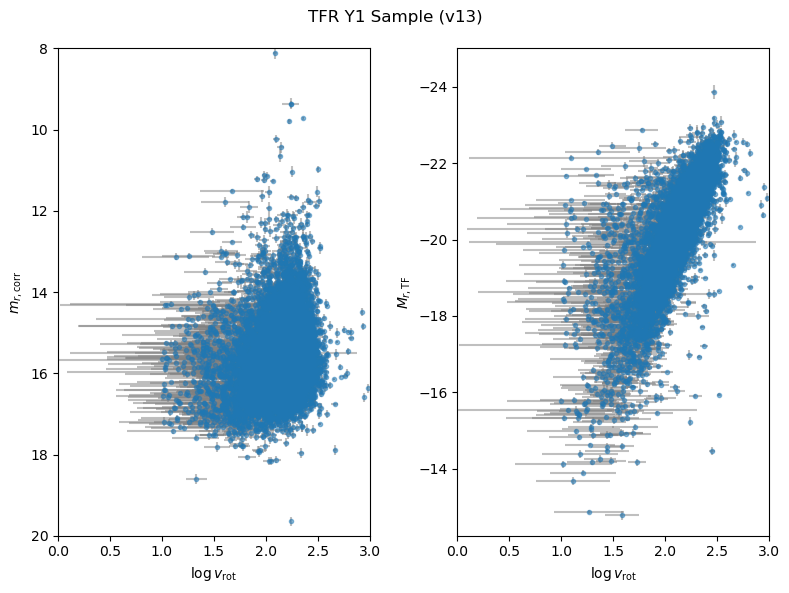

In [21]:
fig, axes = plt.subplots(1,2, figsize=(8,6), tight_layout=True, sharex=True)

ax = axes[0]
ax.errorbar(tfrcat['logv_rot'], tfrcat['R_MAG_SB26_CORR'],
             xerr=tfrcat['logv_rot_err'],
             yerr=tfrcat['R_MAG_SB26_ERR_CORR'],
             fmt='.', 
             alpha=0.5, 
             ecolor='gray')

ax.set(xlim=(0,3),
       xlabel=r'$\log{v_\mathrm{rot}}$',
       ylabel=r'$m_{r,\mathrm{corr}}$',
       ylim=(20,8))

ax = axes[1]
ax.errorbar(tfrcat['logv_rot'], tfrcat['R_ABSMAG_SB26'],
             xerr=tfrcat['logv_rot_err'],
             yerr=tfrcat['R_ABSMAG_SB26_ERR'],
             fmt='.', 
             alpha=0.5, 
             ecolor='gray')

ax.set(xlim=(0,3),
       xlabel=r'$\log{v_\mathrm{rot}}$',
       ylabel=r'$M_{r,\mathrm{TF}}$',
       ylim=(-12.25, -25))

fig.suptitle('TFR Y1 Sample (v13)');
# fig.savefig('tfr_y1_sample.png', dpi=180);

### Generate Absolute Magnitudes for TFR Fitting

Procedure:
1. Calculate $M_{r,\mathrm{cos}}$ using $z_\mathrm{cos}$ from the mocks. This explicitly excludes mock peculiar velocities.
2. Compute distance moduli $\mu$ for each *observed* redshift in the mocks, $z_\mathrm{obs}$.
3. Compute $M_{r,\mathrm{obs}}$ using $m_{r,\mathrm{SB26}}$ from cross-matched from data and the generated $\mu$.
4. Sample $\log{V_\mathrm{rot}}$ by binning the Y1 data in magnitude, computing the $\log{v_\mathrm{rot}}$ CDF in each bin, and randomly sampling a value for each mock galaxy.

In [22]:
#- 1. distmod with cosmological redshifts to compute a "true" absolute magnitude M_r(SB26).
Mr_cos_mock = mock['R_MAG_SB26_CORR'] - cosmology.distmod(mock['zcos']).to_value('mag')

#- 2. Compute an observed magnitude based on the PVs in the mock catalog.
mu_obs_mock = cosmology.distmod(mock['zobs']).to_value('mag')
Mr_obs_mock = (mock['R_MAG_SB26_CORR'] - mu_obs_mock).to_numpy()
Mr_obs_err_mock = mock['R_MAG_SB26_ERR_CORR'].to_numpy()

#- Bin R_ABSMAG_SB26. Merge any bins with < 50 datapoints, working from the ends of the magnitude range.
bins = np.arange(-26, -12 + 0.05, 0.05)
M_r_bins = [bins[0]]
for k in np.arange(1, len(bins)):
    select = (tfrcat['R_ABSMAG_SB26'] > M_r_bins[-1]) & (tfrcat['R_ABSMAG_SB26'] <= bins[k])    
    if np.sum(select) >= 50:
        M_r_bins.append(bins[k])
M_r_bins.append(bins[-1])
N_bins = len(M_r_bins)

print(np.histogram(tfrcat['R_ABSMAG_SB26'], M_r_bins))

#- Loop through the magnitude bins and generate log(v_rot) by resampling the data.
#  Try to reduce resampling effects by using a smoothed version of the CDF of log(v_rot).
logvrot_mock = np.zeros(len(Mr_cos_mock))

use_weighted_fit = True

for k in tqdm(np.arange(0, N_bins-1)):
    M_r_min, M_r_max = M_r_bins[k], M_r_bins[k+1]

    #- Select TFR velocity data in this magnitude bin and compute the CDF of log(v_rot).
    i = (tfrcat['R_ABSMAG_SB26'] > M_r_min) & (tfrcat['R_ABSMAG_SB26'] <= M_r_max)
    logvrot_slice = tfrcat['logv_rot'][i].to_numpy()
    logvrot_err_slice = tfrcat['logv_rot_err'][i].to_numpy()

    if use_weighted_fit:
        #-Attempt to built a weighted CDF
        logvrot_bins = np.arange(1, 3.01, 0.01)
        logvrot_pdf_wt, logv_bins = np.histogram(logvrot_slice, bins=logvrot_bins, 
                                                 weights=np.ones_like(logvrot_err_slice)
                                                 # weights=1/logvrot_err_slice**2
                                                )
        logvrot_cdf = np.cumsum(logvrot_pdf_wt) / np.sum(logvrot_pdf_wt)
        
        logvrot_slice = 0.5*(logvrot_bins[1:] + logvrot_bins[:-1])

        #- Keep only the unique elements in the list
        idx = np.cumsum([len(list(g)) for k, g in groupby(logvrot_cdf)])[:-1]
        logvrot_cdf = logvrot_cdf[idx]
        logvrot_slice = logvrot_slice[idx]
        # print(logvrot_cdf.shape, logvrot_slice.shape)
    else:
        #- Default to use the unweighted CDF
        logvrot_cdf = np.cumsum(logvrot_slice) / np.sum(logvrot_slice)

    #- Select mock data in this magnitude bin.
    # j = (Mr_obs_mock > M_r_min) & (Mr_obs_mock <= M_r_max)
    j = (Mr_cos_mock > M_r_min) & (Mr_cos_mock <= M_r_max)
    N_mock_slice = np.sum(j)
    un = np.random.uniform(size=N_mock_slice)
    logvrot_mock_slice = csaps(logvrot_cdf, np.sort(logvrot_slice), un).values
    logvrot_mock[j] = logvrot_mock_slice

    #- Apply a velocity cut of 70 to 300 km/s and Alex's sliding velocity cut.
    #  Regenerate any velocities that fall outside the valid range.
    #  Note that an intermediate variable is needed to manage the array slicing.
    bad_vrot = (logvrot_mock[j] < 1) | (logvrot_mock[j] > 3)
    # bad_vrot = (logvrot_mock[j] < logVmin) | (logvrot_mock[j] > logVmax) | (logvrot_mock[j] > logVMmax[j])
    while np.any(bad_vrot):
        N_regen = np.sum(bad_vrot)
        uni = np.random.uniform(size=N_regen)
        logvrot_mock_regen = logvrot_mock[j]
        logvrot_mock_regen[bad_vrot] = csaps(logvrot_cdf, np.sort(logvrot_slice), uni).values
        logvrot_mock[j] = logvrot_mock_regen
        bad_vrot = (logvrot_mock[j] < 1) | (logvrot_mock[j] > 3)
        # bad_vrot = (logvrot_mock[j] < logVmin) | (logvrot_mock[j] > logVmax) | (logvrot_mock[j] > logVMmax[j])

# #- Next, scatter in the Mr_obs, logvrot plane using the sigma fit from the data,
# #  projected onto the best fit line in the TFR Y1 *data*. Use this projected sigma
# #  to scatter the mock Mr_obs vs logvrot.
# slope = np.asarray([-a, 1.])
# slope = slope / np.sqrt(np.dot(slope, slope))

# logging.warning('Using a fudge factor in sigma. Revisit!')
# scale = np.random.normal(0, 0.13*sigma, len(Mr_obs))
# logvrot_mock = logvrot + scale*slope[0]
# Mr_obs_mock = Mr_obs + scale*slope[1]

#- Finally, match mock values against the Y1 data to assign uncertainties on logvrot_mock and Mr_obs_mock.
#  Many ways to do this... here just copy the FP approach of grabbing the nearest neighbor in (log v, M_r)
#  from data and taking its uncertainty.
search_tree = KDTree(np.c_[tfrcat['logv_rot'], tfrcat['R_ABSMAG_SB26']])
search_tree.query([1.5, -20])
_, idx = search_tree.query([[x, y] for (x,y) in zip(logvrot_mock, Mr_obs_mock)])

logvrot_err_mock = tfrcat['logv_rot_err'][idx].to_numpy()
Mr_obs_err_mock = mock['R_MAG_SB26_ERR_CORR'].to_numpy()

mock['LOGVROT_MOCK'] = logvrot_mock
mock['LOGVROT_ERR_MOCK'] = logvrot_err_mock
mock['R_ABSMAG_SB26_MOCK'] = Mr_obs_mock
mock['R_ABSMAG_SB26_ERR_MOCK'] = Mr_obs_err_mock

(array([ 68,  56,  55,  77,  95,  71,  57,  67,  82, 101, 112, 119, 120,
       142, 170, 145, 163, 160, 170, 160, 175, 196, 173, 202, 208, 198,
       188, 176, 183, 202, 175, 174, 184, 209, 178, 164, 163, 162, 175,
       163, 153, 152, 170, 150, 153, 137, 131, 142, 124, 106, 122, 124,
       102, 126,  97, 111,  92,  89,  92,  93,  91, 100,  86,  77,  63,
        67,  71,  53,  59,  55,  53,  99,  66,  51,  96,  86,  82,  64,
        60,  68,  59,  57,  61,  51,  57,  56,  52,  51,  51,  16]), array([-26.  , -22.5 , -22.35, -22.25, -22.15, -22.05, -22.  , -21.95,
       -21.9 , -21.85, -21.8 , -21.75, -21.7 , -21.65, -21.6 , -21.55,
       -21.5 , -21.45, -21.4 , -21.35, -21.3 , -21.25, -21.2 , -21.15,
       -21.1 , -21.05, -21.  , -20.95, -20.9 , -20.85, -20.8 , -20.75,
       -20.7 , -20.65, -20.6 , -20.55, -20.5 , -20.45, -20.4 , -20.35,
       -20.3 , -20.25, -20.2 , -20.15, -20.1 , -20.05, -20.  , -19.95,
       -19.9 , -19.85, -19.8 , -19.75, -19.7 , -19.65, -19.6 , -19.55,
 

100%|██████████| 90/90 [00:00<00:00, 278.17it/s]


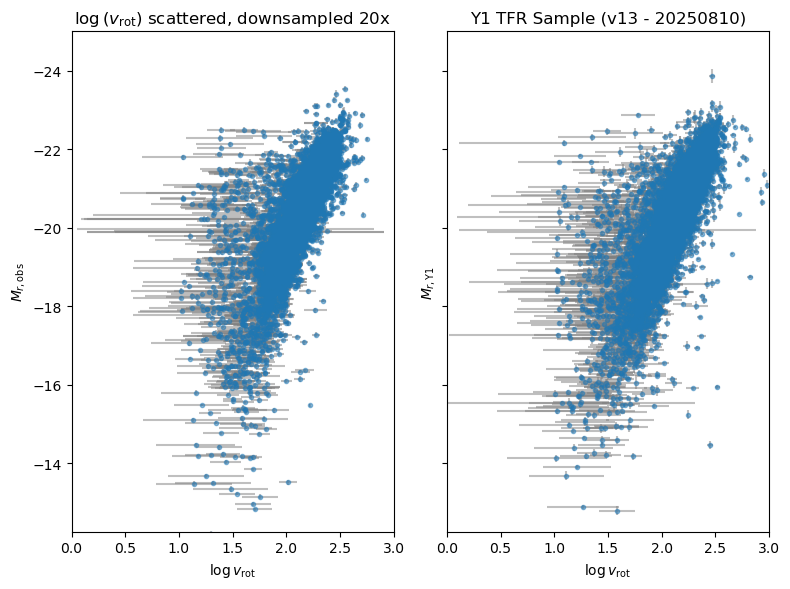

In [23]:
#- Plot Mr vs log(v_rot) for the various steps in the calculation.

fig, axes = plt.subplots(1,2, figsize=(8,6), tight_layout=True, sharex=True, sharey=True)
'''
ax = axes[0]
ax.errorbar((((Mr_cos_mock - b0pt) / a) + logV0)[::20], Mr_cos_mock[::20],
             # xerr=tfrcat['logv_rot_err'],
             # yerr=tfrcat['R_MAG_SB26_ERR_CORR'],
             fmt='.', 
             alpha=0.5, 
             ecolor='gray')

ax.set(xlim=(0,3),
       xlabel=r'$\log{v_\mathrm{rot}}$',
       ylabel=r'$M_{r,\mathrm{cos}}$',
       ylim=(-12.25, -25),
       title=r'$M_{r,\mathrm{cos}}$ generated with $z_\mathrm{cos}$')

ax = axes[1]
ax.errorbar((((Mr_cos_mock - b0pt) / a) + logV0)[::20], Mr_obs_mock[::20],
             # xerr=tfrcat['logv_rot_err'],
             # yerr=tfrcat['R_MAG_SB26_ERR_CORR'],
             fmt='.', 
             alpha=0.5, 
             ecolor='gray',
             label=r'base $M_{r,\mathrm{obs}}$')

ax.errorbar(logvrot[::20], Mr_obs_mock[::20],
             # xerr=tfrcat['logv_rot_err'],
             # yerr=tfrcat['R_MAG_SB26_ERR_CORR'],
             fmt='.', 
             alpha=0.5, 
             ecolor='gray',
             label=r'with uncertainty on $a$, $b$')

ax.legend(loc='upper left')

ax.set(xlim=(0,3),
       xlabel=r'$\log{v_\mathrm{rot}}$',
       ylabel=r'$M_{r,\mathrm{obs}}$',
       ylim=(-12.25, -25),
       title=r'$M_{r,\mathrm{obs}}$ generated with $z_\mathrm{obs}$')
'''
ax = axes[0]
ax.errorbar(
            mock['LOGVROT_MOCK'][::20], mock['R_ABSMAG_SB26_MOCK'][::20],
            xerr=mock['LOGVROT_ERR_MOCK'][::20],
            yerr=mock['R_ABSMAG_SB26_ERR_MOCK'][::20],
            # logvrot_mock[::20], Mr_obs_mock[::20],
            # xerr=logvrot_err_mock[::20],
            # yerr=Mr_obs_err_mock[::20],
            fmt='.', 
            alpha=0.5, 
            ecolor='gray')

ax.set(xlim=(0,3),
       xlabel=r'$\log{v_\mathrm{rot}}$',
       ylabel=r'$M_{r,\mathrm{obs}}$',
       ylim=(-12.25, -25),
       title=r'$\log{(v_\mathrm{rot})}$ scattered, downsampled 20x')

ax = axes[1]
ax.errorbar(tfrcat['logv_rot'], tfrcat['R_ABSMAG_SB26'],
             xerr=tfrcat['logv_rot_err'],
             yerr=tfrcat['R_ABSMAG_SB26_ERR'],
             fmt='.', 
             alpha=0.5, 
             ecolor='gray')

ax.set(xlim=(0,3),
       xlabel=r'$\log{v_\mathrm{rot}}$',
       ylabel=r'$M_{r,\mathrm{Y1}}$',
       ylim=(-12.25, -25),
       title='Y1 TFR Sample (v13 - 20250810)');

# fig.savefig('tfr_mock_mr_vs_logv.png', dpi=150);

### Compute the Maximum Volume for each Galaxy

Since the SGA is size-limited, with $D_{26}>0.2'$, there is a maximum volume within which the galaxy could be located to be included in the SGA. Calculate the maximum volume to be used as a weight in the TFR calibration.

In [24]:
dist = cosmology.luminosity_distance(np.abs(mock['zobs']))
dist_max = cosmology.luminosity_distance(z=0.1)
d26_kpc = 2*dist.to('kpc') * np.tan(0.5*mock['D26'].values*u.arcmin)
mock_dist_max = 0.5*d26_kpc / np.tan(0.1*u.arcmin)
# surv_max = cosmology.luminosity_distance(z=0.2)

# mock['D26_kpc'] = 2*dist.to_value('kpc') * np.tan(0.5*mock['D26'].values*u.arcmin)
# mock['DIST_MAX'] = 0.5*mock['D26_kpc'].values / np.tan(0.1*u.arcmin)
# mock['MAX_VOL_FRAC'] = (1e-3 * mock['DIST_MAX'].values)**3 / dist_max.to_value('Mpc')**3
mock['MAX_VOL_FRAC'] = mock_dist_max.to('Mpc')**3 / dist_max.to('Mpc')**3

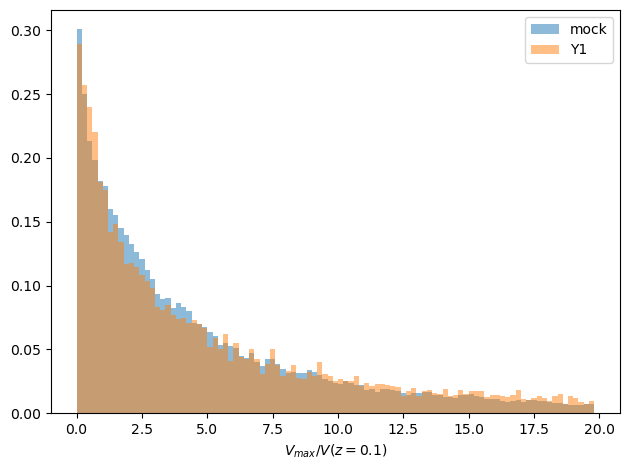

In [25]:
plt.figure(tight_layout=True)

iron_dist = cosmology.luminosity_distance(np.abs(tfrcat['Z_DESI'].values))
iron_d26kpc = 2*iron_dist.to('kpc') * np.tan(0.5*tfrcat['D26'].values*u.arcmin)
iron_dist_max = 0.5*iron_d26kpc / np.tan(0.1*u.arcmin)

plt.hist(mock['MAX_VOL_FRAC'], np.arange(0, 20, 0.2), density=True, alpha=0.5, label='mock')
plt.hist(iron_dist_max.to('Mpc')**3 / dist_max.to('Mpc')**3, np.arange(0, 20, 0.2), density=True, alpha=0.5, label='Y1')

plt.legend()

plt.xlabel('$V_{max}$/$V(z = 0.1)$');

### What is the size distribution of galaxies with $M_r > -17$?

Our usual definition of a dwarf galaxy is to have $M_r > -17$.  Because we don't know this for the data a priori, can we use the galaxy's size as a proxy?

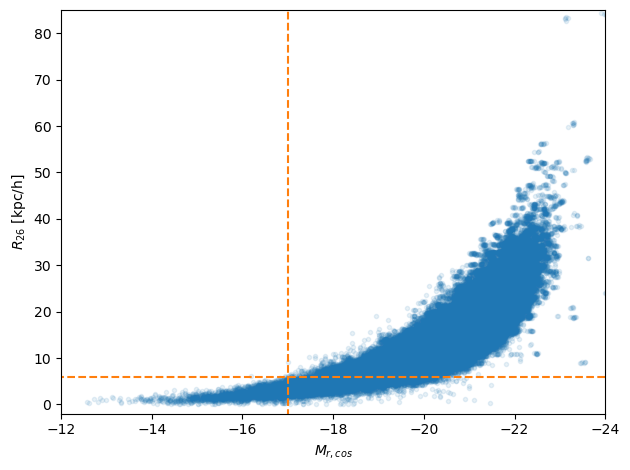

In [26]:
plt.figure(tight_layout=True)

plt.plot(Mr_cos_mock, 0.5*d26_kpc, '.', alpha=0.1)

plt.vlines(-17, -5, 90, colors='tab:orange', linestyles='dashed')
plt.hlines(6, -24, -12, colors='tab:orange', linestyles='dashed')

plt.xlim(-12, -24)
plt.ylim(-2, 85)

plt.xlabel('$M_{r, cos}$')
plt.ylabel('$R_{26}$ [kpc/h]');

In [27]:
# Alex's definition for dwarfs
Rlim = 17.75
Mlim = -17 + 5*np.log10(h)

Rlim_eff = np.minimum(Rlim, mu_obs_mock + Mlim)
mock_dwarfs = mock['R_MAG_SB26'] > Rlim_eff

### Fit the TFR and Compute Mock Distance Moduli

Fit $M_{r,\mathrm{obs,mock}}$ versus $\log{V_\mathrm{rot,mock}}$ to get a mock TFR.

Then compute the TF distance modulus as

$$
\mu_\mathrm{mock} = m_{r,\mathrm{SB_{26}}} - M_{r,\mathrm{obs,mock}},
$$

where the apparent magnitude is the quantity `R_MAG_SB26_CORR` used to compute magnitudes from the cosmological and observed redshift.

#### Implement Alex's velocity cuts

In [28]:
# Alex's velocity cuts
logVmin = np.log10(70)
logVmax = np.log10(300)

logVM_slope = 0.3
logVM_zero = 34 + 5*np.log10(h)
logVMmax = np.minimum(logVmax, logVM_slope*(mu_obs_mock - logVM_zero) + 2)

mock_goodV = (logvrot_mock > logVmin) & (logvrot_mock < logVmax) & (logvrot_mock < logVMmax)

#### Create a "data" sample with which to fit

In [44]:
#- Only use non-dwarf galaxies with good velocities
mock_main = ~mock_dwarfs & mock_goodV

# Bin the galaxies
zbin_indices = np.digitize(mock['zobs'], zbins, right=True)

# Downsample the set so that have roughly the same statistics as we have with the data
# dz = 0.005 --> 116-356 galaxies in each redshift bin
# dz = 0.001 --> 22-97 galaxies in each redshift bin
Ns = 300
idx = np.zeros(len(mock), dtype=bool)
row_idx = np.arange(len(mock))

for i in range(1,len(zbins)):
    
    # Identify all good galaxies in this bin
    bin_idx = (zbin_indices == i) & mock_main

    if np.sum(bin_idx) > 0:
    
        # Get a list of the index values of these galaxies
        bin_row_num = row_idx[bin_idx]
        
        # Randomly select a subsample of these galaxies to use in the fit
        use_idx = np.random.choice(bin_row_num, size=Ns, replace=False)
    
        # Set these indices to True
        idx[use_idx] = True

#### Pack the data for `MultiLinFit`

In [45]:
# Determine logV0 for the test calibration
# logV0_mock = np.median(logvrot_mock[idx])
logV0_mock = np.median(logvrot_mock)
print(logV0_mock)

# Pack the calibration set into lists
logv, dlogv = [], []
mr, dmr = [], []
weights = []

# Loop over the redshift bins
for k in range(1,len(zbins)):

    # Identify objects in this bin
    bin_idx = zbin_indices == k

    # Identify those which we are going to calibrate with
    cal_idx = bin_idx & idx

    logv.append(logvrot_mock[cal_idx] - logV0_mock)
    dlogv.append(logvrot_err_mock[cal_idx])
    mr.append(mock['R_MAG_SB26_CORR'].to_numpy()[cal_idx])
    dmr.append(mock['R_MAG_SB26_ERR_CORR'].to_numpy()[cal_idx])
    # weights.append(np.ones(np.sum(cal_idx)))
    weights.append(1/mock['MAX_VOL_FRAC'].to_numpy()[cal_idx])

2.17038362954266


#### Fit with `MultiLinFit`

In [31]:
# Number of redshift bins
m = len(logv)

bounds = [[-20, 0]]        # Bounds on a (slope)
bounds += m*[(-20, 20)]    # Bounds on b (intercepts: z-bins)
bounds += [(0,5)]          # Bounds on sigma

# logging.warning('Fit does not account for volume weights.')

results = hyperfit_line_multi(logv, mr, dlogv, dmr, bounds, weights=weights, scatter=1)

a_mcmc, b_mcmc, sigma_mcmc, cov_mcmc, mcmc_samples, hf = results

     fun: -865955.1533199119
     jac: array([-2.9220246 , -1.862645  ,  0.48894431,  1.16415312, -2.95694893,
        0.1862645 ,  0.44237819,  1.93249418,  0.12805684,  3.36440252,
        0.23283062, -0.5238689 , -0.5238689 ,  1.32713456, -2.27009859,
        1.04773781,  6.00703058])
 message: 'Optimization terminated successfully.'
    nfev: 49212
     nit: 191
 success: True
       x: array([-7.60311278, 14.3032111 , 14.70958334, 15.04478395, 15.33401509,
       15.4281275 , 15.66624014, 15.81147673, 16.05335832, 16.2151025 ,
       16.44983215, 16.52703298, 16.63785199, 16.81106758, 16.93517982,
       17.04052318,  0.56779953])
Ndim: 17 15


100%|██████████| 1000/1000 [00:51<00:00, 19.33it/s]


Niterations/Max Iterations:  1000 / 100000
Integrated ACT/Min Convergence Iterations:  [71.37551287 54.25377519 59.69352123 57.22908354 58.76250506 53.65641654
 75.38743503 61.59104859 80.67770535 67.45392969 62.2632825  73.40318332
 74.11873553 69.84531129 87.57439635 69.2902157  73.78605716] / 4378.719817301763


100%|██████████| 1000/1000 [00:52<00:00, 18.98it/s]


Niterations/Max Iterations:  2000 / 100000
Integrated ACT/Min Convergence Iterations:  [98.2368867  67.99431954 65.92615136 67.14124057 73.64729675 71.13797899
 83.070911   82.43665051 85.113655   78.12834624 92.69453096 93.67492179
 87.34362577 82.00686533 82.30472792 89.27268113 95.12416766] / 4911.844335061682


100%|██████████| 1000/1000 [00:53<00:00, 18.65it/s]


Niterations/Max Iterations:  3000 / 100000
Integrated ACT/Min Convergence Iterations:  [113.89634155  75.47896732  66.02125929  80.94009394  74.35666907
  79.72969482  92.71302358  92.86216542  93.71296305  95.36692362
  88.21698733 100.05375724  91.50355174  91.38084292 101.83186191
  99.17965042 117.69355048] / 5884.677523796133


100%|██████████| 1000/1000 [00:52<00:00, 19.10it/s]


Niterations/Max Iterations:  4000 / 100000
Integrated ACT/Min Convergence Iterations:  [111.94581519  77.2446288   76.03793095  83.44535932  84.16488225
  82.36499513 100.91504083  98.76105612 102.06416343 104.34553347
  93.9500899  112.58864826 104.09854398 106.36345425  96.69907552
 102.17120218 117.57809011] / 5878.904505282679


100%|██████████| 1000/1000 [00:51<00:00, 19.29it/s]


Niterations/Max Iterations:  5000 / 100000
Integrated ACT/Min Convergence Iterations:  [121.6789256   80.26032403  89.09718773  93.44024453  92.5237476
  90.33363303 105.6965979  100.59912027  98.8886721  106.34500148
  99.65123899 121.8385741  116.07680548 115.62354111 108.95082119
  98.12003125 119.18424104] / 6091.928704840448


100%|██████████| 1000/1000 [00:52<00:00, 19.18it/s]


Niterations/Max Iterations:  6000 / 100000
Integrated ACT/Min Convergence Iterations:  [129.59494536  81.57174061  89.0293151   95.16112738  97.40922214
  93.32221217 108.63094027  98.38721726  95.29004358 103.43463123
  98.39462851 118.33183507 121.10726805 116.11991285 111.78141004
 107.37798241 126.31297718] / 6479.747267878906


100%|██████████| 1000/1000 [00:51<00:00, 19.27it/s]


Niterations/Max Iterations:  7000 / 100000
Integrated ACT/Min Convergence Iterations:  [134.45350408  81.597916    91.90760302  99.57421387  91.507991
  93.9803647   99.77462246  99.33628354 104.67941747 108.79943728
 107.1720393  118.19043383 117.77628759 113.68219526 112.50775085
 118.87253724 151.50441157] / 7575.2205784459275


100%|██████████| 1000/1000 [00:50<00:00, 19.71it/s]


Niterations/Max Iterations:  8000 / 100000
Integrated ACT/Min Convergence Iterations:  [138.79756255  85.96430655  94.220082    94.42003002  96.57514566
 101.80729485  97.35893174 103.35176675 106.59730841 115.52066545
 110.15788046 125.40103648 116.86576038 120.35369559 112.18671149
 123.16773304 140.5102275 ] / 7025.51137499871


100%|██████████| 1000/1000 [00:52<00:00, 19.22it/s]


Niterations/Max Iterations:  9000 / 100000
Integrated ACT/Min Convergence Iterations:  [142.34369108  88.99736116  91.09276287  93.27663567  99.40160848
 101.28681017 101.44540439 113.44570452 106.32693969 117.9824533
 110.7749437  120.52465133 120.96844592 127.79649976 110.69883133
 129.15595046 144.52353454] / 7226.176727059219


100%|██████████| 1000/1000 [00:51<00:00, 19.27it/s]


Niterations/Max Iterations:  10000 / 100000
Integrated ACT/Min Convergence Iterations:  [145.60618373  90.79533859  93.51360459  96.77465431 106.97172118
  98.72348508  99.12844777 110.41029995 105.30972213 116.83023361
 112.43874335 125.38447396 121.06724501 128.08093841 113.46636944
 133.5148865  144.26966541] / 7280.309186651283


100%|██████████| 1000/1000 [00:51<00:00, 19.51it/s]


Niterations/Max Iterations:  11000 / 100000
Integrated ACT/Min Convergence Iterations:  [151.07223252  88.32548144  93.1822637   94.67488719 107.90229631
  98.01542681 102.10248766 111.147623   108.14068576 114.59663086
 112.66657224 124.02764179 123.54587125 132.19831198 115.73555431
 137.1468204  152.15025232] / 7607.512616156229


100%|██████████| 1000/1000 [00:51<00:00, 19.24it/s]


Niterations/Max Iterations:  12000 / 100000
Integrated ACT/Min Convergence Iterations:  [154.53096998  90.35500608  96.38402174  98.61661734 111.87675547
 102.4383999  106.07861454 105.31674587 106.24002437 117.28881105
 112.05595418 128.83340289 121.13447018 138.66137946 113.26498492
 137.99020501 153.76805989] / 7726.548498996559


100%|██████████| 1000/1000 [00:52<00:00, 19.21it/s]


Niterations/Max Iterations:  13000 / 100000
Integrated ACT/Min Convergence Iterations:  [155.96005564  90.59643943  93.33027674  99.62801537 110.20219557
  99.42655518 105.5493989  107.67247253 107.56708604 118.74360116
 116.82615918 131.3408954  123.78146099 144.3543855  112.03927778
 151.13050984 157.44269318] / 7872.134658881689


100%|██████████| 1000/1000 [00:52<00:00, 19.11it/s]


Niterations/Max Iterations:  14000 / 100000
Integrated ACT/Min Convergence Iterations:  [151.96829205  89.78674224  96.72253551 100.54590253 109.11728837
 107.97266588 104.85861462 106.56228997 109.45095416 119.80617904
 123.68058057 133.92164804 130.11937615 142.81087619 112.29410716
 140.57384781 155.23154665] / 7761.577332413543


100%|██████████| 1000/1000 [00:52<00:00, 19.19it/s]


Niterations/Max Iterations:  15000 / 100000
Integrated ACT/Min Convergence Iterations:  [156.57917968  93.15759632  96.28862937  98.47295659 106.14239079
 105.5063681  106.00418291 106.99716424 110.72694878 119.45703864
 125.89076836 137.74778036 132.91341291 138.88932594 113.53752797
 139.99181475 162.7118812 ] / 8135.594059973952


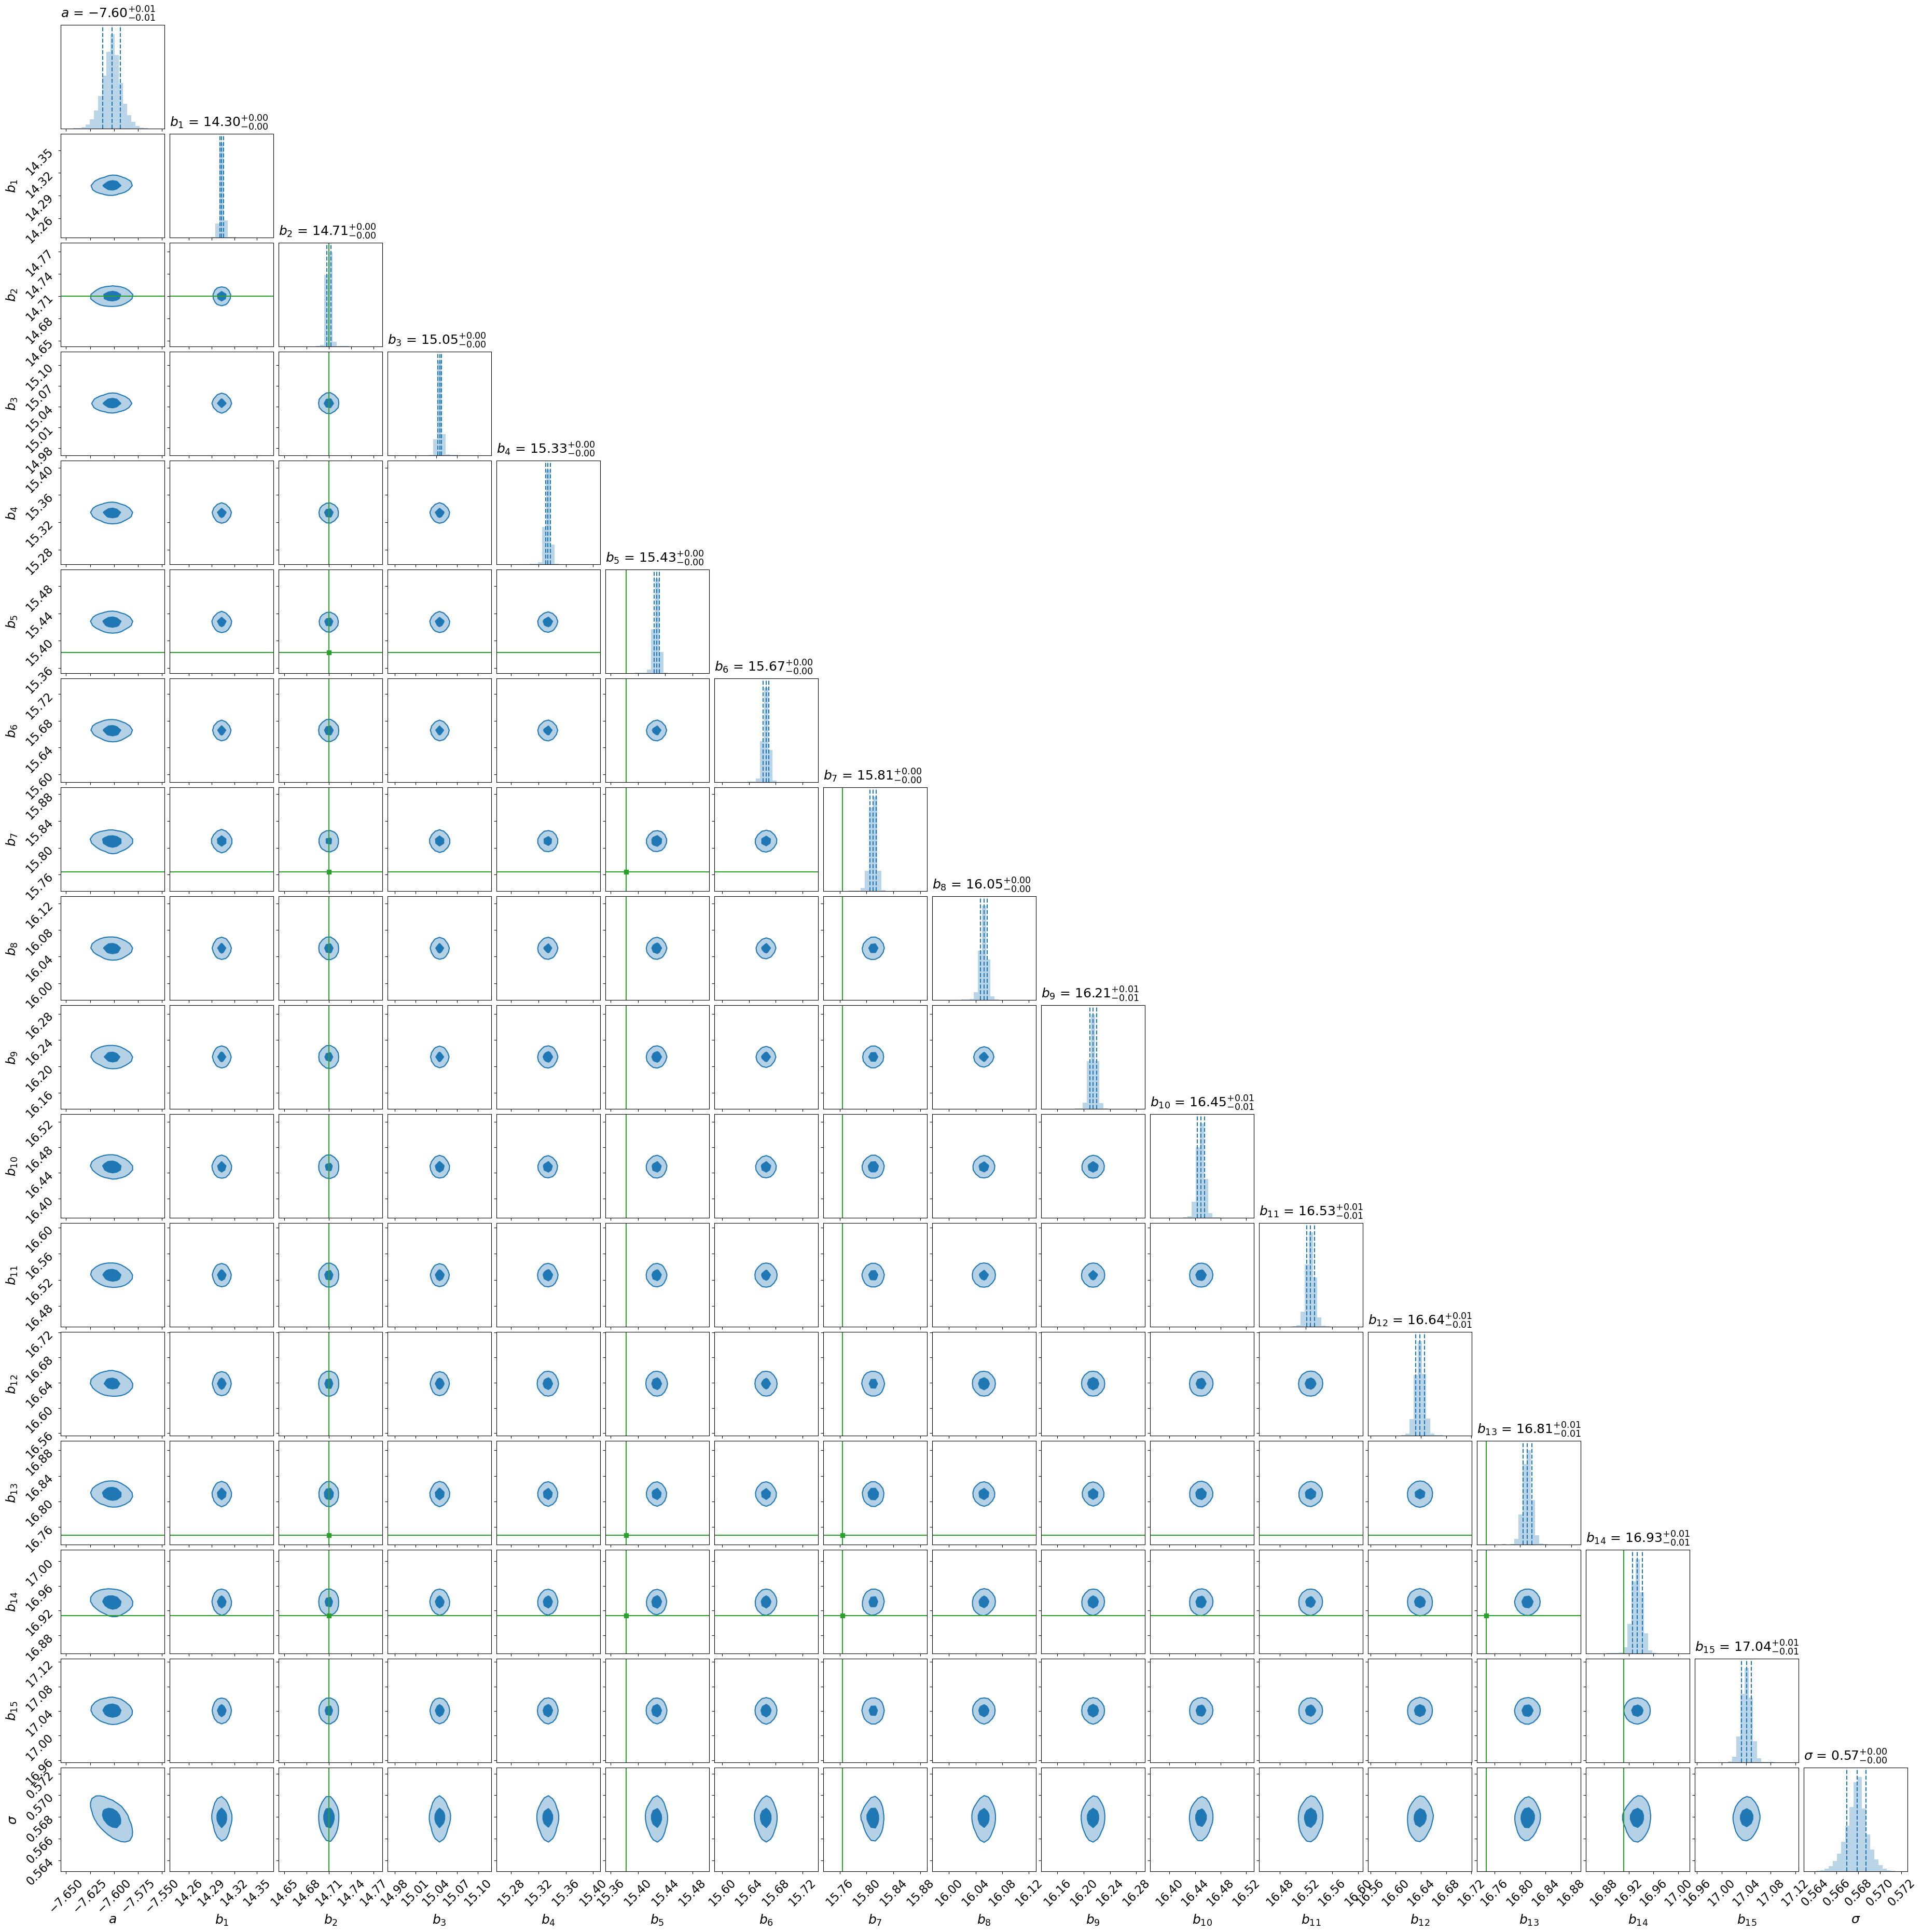

In [32]:
labels  = ['$a$']
labels += [f'$b_{{ {k+1} }}$' for k in np.arange(m)]
labels += [r'$\sigma$']

fig = corner(mcmc_samples.T, bins=25, smooth=1,
             labels=labels,
             label_kwargs={'fontsize':18},
             labelpad=0.1,
             levels=(1-np.exp(-0.5), 1-np.exp(-2)),
             quantiles=[0.16, 0.5, 0.84],
             color='tab:blue',
             hist_kwargs={'histtype':'stepfilled', 'alpha':0.3},
             plot_datapoints=False,
             fill_contours=True,
             truths=tf_par,
             truth_color='tab:green',
             show_titles=True,
             title_kwargs={"fontsize": 18, 'loc':'left', 'pad':10});

for ax in fig.get_axes():
    ax.tick_params(axis='both', which='major', labelsize=16);

# fig.savefig('tfr_mock_calibration_mcmc.png', dpi=150)

In [33]:
tf_par

array([-7.20176565, 14.39441625, 14.70989495, 14.9373865 , 15.16461899,
       15.38282027, 15.58256514, 15.76429503, 15.9358268 , 16.07575333,
       16.23118681, 16.40326623, 16.52451628, 16.74717343, 16.91192428,
       16.85607594,  0.46511205])

In [39]:
a_mcmc, b_mcmc, sigma_mcmc

(-7.601988346652608,
 array([14.30339598, 14.7098337 , 15.04504994, 15.33378129, 15.42767454,
        15.66545731, 15.81012881, 16.05250232, 16.2144066 , 16.44941649,
        16.52702403, 16.63856157, 16.81170585, 16.93384925, 17.04064662]),
 array([0.56790987]))

#### Quick Check of Many Realizations of the "Calibration" Sample

In [35]:
N = len(logvrot_mock)
Ns = 150

a_real, b_real, sigma_real = [], [], []

for i in tqdm(np.arange(100)):
    idx = np.random.choice(N-1, size=Ns, replace=False)

    logV0_mock = np.median(logvrot_mock)

    logv  = logvrot_mock[idx] - logV0_mock
    dlogv = logvrot_err_mock[idx]
    Mr  = Mr_obs_mock[idx]
    dMr = Mr_obs_err_mock[idx]
    weights = np.ones_like(logv)
    # weights = 1/mock['MAX_VOL_FRAC'].to_numpy()[idx]
    
    mock_dat = np.empty((2, Ns))
    mock_cov = np.empty((2, 2, Ns))
    
    logv, Ns, len(logv)
    
    for k in range(Ns):
        mock_dat[:, k] = np.array([logv[k], Mr[k]])
        mock_cov[:,:,k] = np.array([[dlogv[k]**2, 0.], [0., dMr[k]**2]])
    
    bounds = [[-20, 0]]                    # Bounds on a (slope)
    bounds += [(-40,0)]                    # Bounds on b (intercepts: 0-pt + clusters)
    bounds += [(0,5)]                      # Bounds on sigma
    
    # logging.warning('Fit does not account for volume weights.')
    
    hf = LinFit(mock_dat, mock_cov, weights=weights)
    (a_bf, b_bf), sigma_bf, ll_bf = hf.optimize(bounds, verbose=False)

    a_real.append(a_bf)
    b_real.append(b_bf),
    sigma_real.append(sigma_bf)
    
    # print(f'a = {a_bf:.3f}')
    # print(f'b = {b_bf:.3f}')
    # print(f'sigma = {sigma_bf:.3f}')

  0%|          | 0/100 [00:00<?, ?it/s]


NameError: name 'LinFit' is not defined

In [ ]:
fig, axes = plt.subplots(1,3, figsize=(12,4), tight_layout=True)

ax = axes[0]
ax.hist(a_real, bins=np.arange(-12.5,-2.4,0.4))
ax.axvline(tf_par[0], color='tab:orange', ls='--')
ax.axvline(np.mean(a_real), color='tab:green')
ax.axvline(np.mean(a_real) - np.std(a_real), color='tab:green', ls='--')
ax.axvline(np.mean(a_real) + np.std(a_real), color='tab:green', ls='--')
ax.set(title=rf'$\hat{{a}}={np.mean(a_real):.2f}\pm{np.std(a_real):.2f}$',
       xlabel=r'slope $a$')

ax = axes[1]
ax.hist(b_real, bins=np.arange(-21.2,-19.95,0.05))
ax.axvline(tf_par[1], color='tab:orange', ls='--')
ax.axvline(np.mean(b_real), color='tab:green')
ax.axvline(np.mean(b_real) - np.std(b_real), color='tab:green', ls='--')
ax.axvline(np.mean(b_real) + np.std(b_real), color='tab:green', ls='--')
ax.set(title=rf'$\hat{{b}}={np.mean(b_real):.2f}\pm{np.std(b_real):.2f}$',
       xlabel=r'zero point $b_\mathrm{0pt}$')

ax = axes[2]
ax.hist(sigma_real, bins=np.arange(-0.1,1.45,0.05))
ax.axvline(tf_par[2], color='tab:orange', ls='--')
ax.axvline(np.mean(sigma_real), color='tab:green')
ax.axvline(np.mean(sigma_real) - np.std(sigma_real), color='tab:green', ls='--')
ax.axvline(np.mean(sigma_real) + np.std(sigma_real), color='tab:green', ls='--')
ax.set(title=rf'$\hat{{\sigma}}={np.mean(sigma_real):.2f}\pm{np.std(sigma_real):.2f}$',
       xlabel=r'magnitude scatter $\sigma$');

# fig.savefig(f'tfr_fit_param_spread_equal_weight_{os.path.basename(mockfile)[:-9]}.png', dpi=150)
# fig.savefig('tfr_fit_param_spread_error_weighted.png', dpi=150)
# fig.savefig('tfr_fit_param_spread_var_weighted.png', dpi=150)

In [ ]:
tf_par

In [ ]:
a_avg = np.average(a_real)
b_avg = np.average(b_real)
sigma_avg = np.average(sigma_real)
a_avg, b_avg, sigma_avg

In [ ]:
a_mcmc, b_mcmc, sigma_mcmc = a_avg, b_avg, sigma_avg

#### Dwarf Cut

In [46]:
#- Apply dwarf cut using galaxy size
mock['DWARF'] = mock_dwarfs

mock['MAIN'] = mock_main

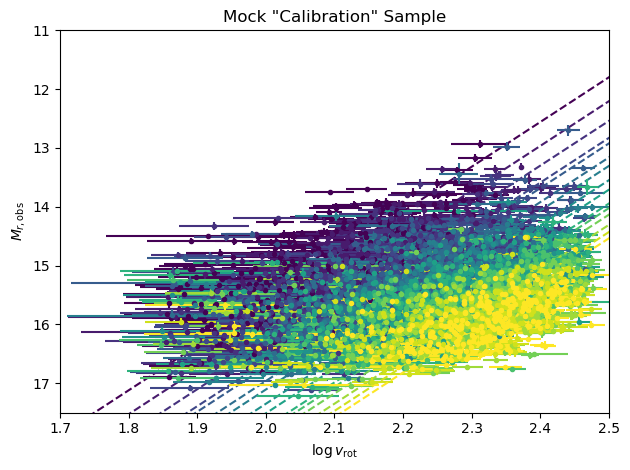

In [47]:
plt.figure(tight_layout=True)

_logv = np.arange(0, 3.1, 0.1)

color = iter(plt.cm.viridis(np.linspace(0,1,m)))
for k in range(m):
    c = next(color)
    plt.errorbar(logv[k] + logV0_mock, mr[k], 
                 xerr=dlogv[k], 
                 yerr=dmr[k], 
                 fmt='.', 
                 c=c)
    plt.plot(_logv, a_mcmc*(_logv - logV0_mock) + b_mcmc[k], color=c, ls='--')

plt.xlim(1.7, 2.5)
plt.ylim(17.5, 11)
plt.xlabel(r'$\log{v_\mathrm{rot}}$')
plt.ylabel(r'$M_{r,\mathrm{obs}}$')
plt.title(r'Mock "Calibration" Sample');

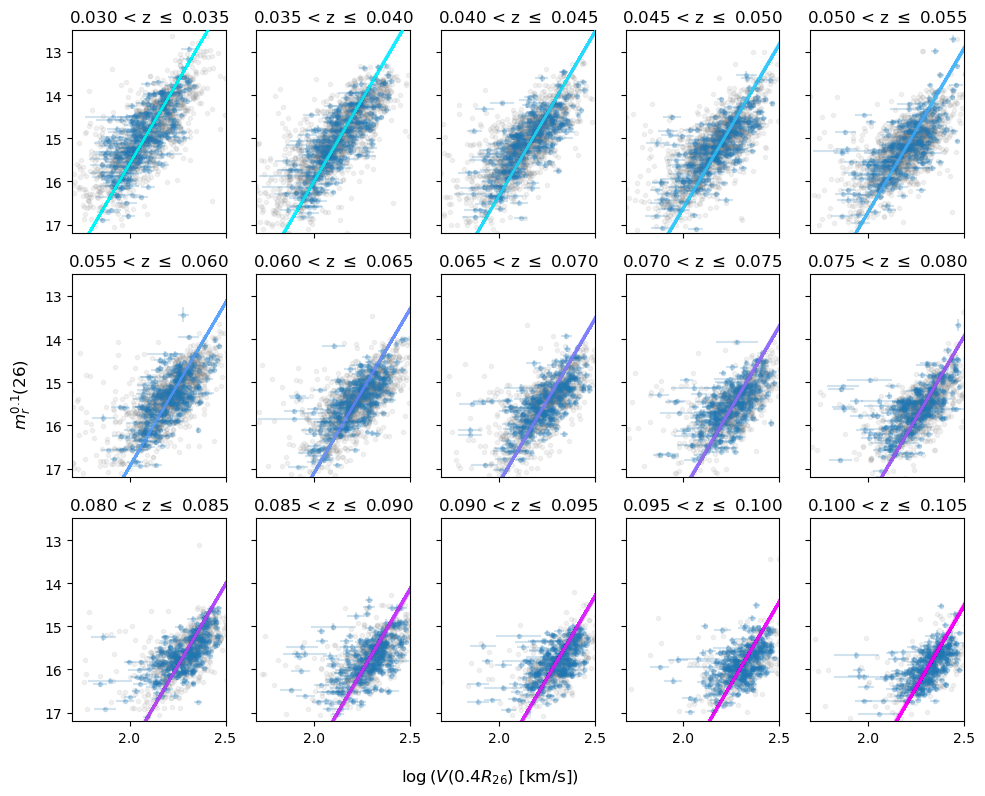

In [48]:
fig, axes = plt.subplots(nrows=3, ncols=5, sharex=True, sharey=True, figsize=(10,8), tight_layout=True)

_logv = np.arange(0, 3.1, 0.5)

color = iter(plt.cm.cool(np.linspace(0,1,m)))
for i in range(m):
    c = next(color)

    row = int(i/5)
    col = i%5

    axes[row,col].plot(logvrot_mock[zbin_indices == i + 1][::10], 
                       mock['R_MAG_SB26_CORR'][zbin_indices == i + 1][::10], 
                       '.', c='gray', alpha=0.1)
    
    axes[row,col].errorbar(logv[i] + logV0_mock, mr[i], 
                           xerr=dlogv[i], 
                           yerr=dmr[i], 
                           fmt='.', 
                           c='tab:blue', 
                           alpha=0.2)

    for (_a, _b) in mcmc_samples[[0,i+1], ::500].T:
        axes[row,col].plot(_logv, _a*(_logv - logV0_mock) + _b, color=c, alpha=0.05, zorder=100)

    axes[row,col].set(xlim=[1.7, 2.5], ylim=[17.2, 12.5], title=f'{zbins[i]:.3f} < z $\leq$ {zbins[i+1]:.3f}')


fig.supxlabel(r'$\log{(V(0.4R_{26})~[\mathrm{km/s}]}$)')
fig.supylabel(r'$m_r^{0.1} (26)$');

### Compute TFR Distance Modulus

Using the "measured" apparent magnitude and the TFR-predicted absolute magnitude from the "calibration" above, compute the distance modulus:

$$
\mu_\mathrm{TF} =  m_{r,\mathrm{SB_{26}}} - M_{r,\mathrm{TF}}.
$$

Also compute the log distance ratio

$$
\eta = \log{\left(\frac{D_z}{D_\mathrm{TFR}}\right)}
$$

In [49]:
#- Compute TF absolute magnitude and uncertainties using the MCMC from HyperFit.
#  Downsample the MCMC significantly for this quick calculation.

#-------------------------------------------------------------------------------
#- First, calculate the distance modulus for each redshift bin
#-------------------------------------------------------------------------------
# Center redshift values of each bin
zc = 0.5*dz + zbins[:-1]

# Distance modulus for each redshift bin center
mu_zc = cosmology.distmod(zc)
#-------------------------------------------------------------------------------
#- Then, convert each redshift bin's y-intercept to an absolute magnitude
#-------------------------------------------------------------------------------
B_mcmc = np.median(tfr_samples[1:-1], axis=1) - mu_zc.value
#-------------------------------------------------------------------------------

B_indices = zbin_indices - 1
# For those galaxies that fall outside the calibration range, assign them to the closest bin
B_indices[zbin_indices == 0] = 0
B_indices[zbin_indices == len(zbins)] = len(zbins) - 2

Mr_TF = a_mcmc * (logvrot_mock - logV0_mock) + B_mcmc[B_indices]

# This method takes up too much memory, and the uncertainties on the parameters 
# are subdominant to the scatter and velocity uncertainties anyway
# a_sampled, B_sampled = mcmc_samples[0][::500], mcmc_samples[B_indices][::500] - mu_zc[B_indices, np.newaxis].value
# Mr_TF_err = np.std(a_sampled * (logvrot_mock[:, np.newaxis] - logV0_mock) + B_sampled, axis=1)
rng = np.random.default_rng()
Mr_TF_err = np.zeros(len(mock))
for i in range(len(mock)):
    logv_random = rng.normal(logvrot_mock[i], 0.434*logvrot_err_mock[i], size=1000)
    Mr_stat = a_mcmc*(logv_random - logV0_mock) + B_mcmc[B_indices[i]]
    Mr_TF_err[i] = np.sqrt(np.nanstd(Mr_stat)**2 + sigma_mcmc**2)

mu_TF = mock['R_MAG_SB26_CORR'] - Mr_TF
mu_TF_err = np.sqrt(mock['R_ABSMAG_SB26_ERR_MOCK']**2 + Mr_TF_err**2)

mu_zcmb = cosmology.distmod(mock['zobs']).to_value('mag')
mu_zcos = cosmology.distmod(mock['zcos']).to_value('mag')

eta_true = 0.2 * (mu_zcmb - mu_zcos)
eta_mock = 0.2 * (mu_zcmb - mu_TF)
# eta_true = 0.2 * (10 - mu_zcos)
# eta_mock = 0.2 * (10 - mu_TF)
eta_err_mock = 0.2 * mu_TF_err

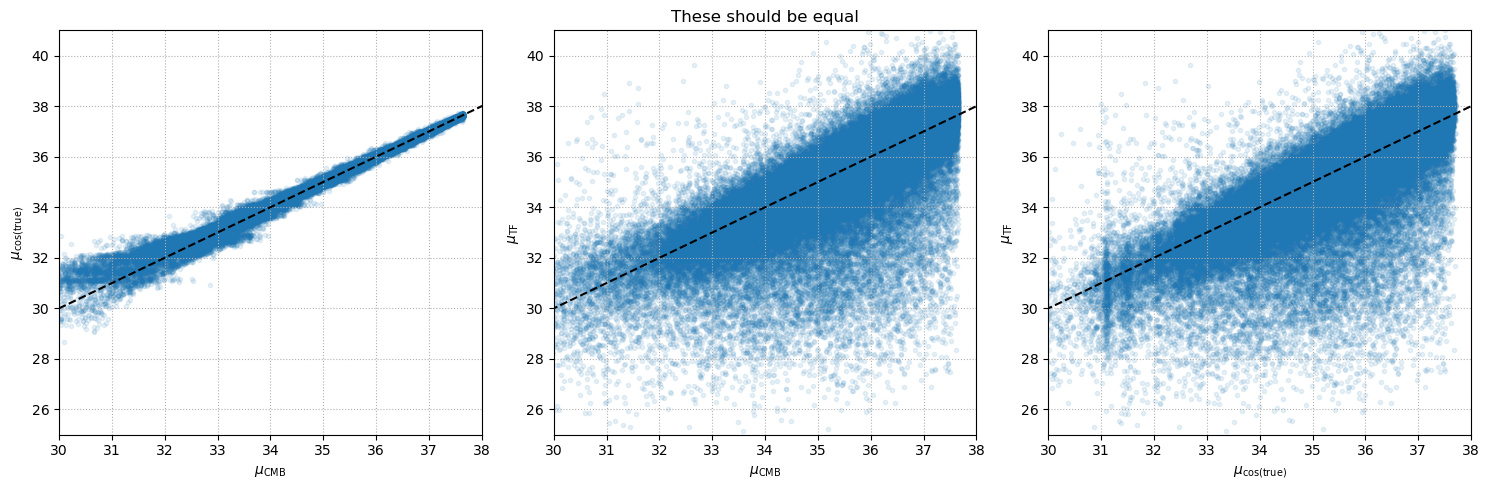

In [50]:
fig, axes = plt.subplots(1,3, figsize=(15, 5), tight_layout=True)


axes[0].plot(mu_zcmb, mu_zcos, '.', alpha=0.1, zorder=0)
axes[0].plot([22, 42], [22, 42], 'k--')
axes[0].grid(ls=':')
axes[0].set(xlim=[30, 38], 
            ylim=[25, 41], 
            ylabel=r'$\mu_\mathrm{cos (true)}$', 
            xlabel=r'$\mu_\mathrm{CMB}$')


axes[1].plot(mu_zcmb, mu_TF, '.', alpha=0.1, zorder=0)
axes[1].plot([22, 42], [22, 42], 'k--')
axes[1].grid(ls=':')
axes[1].set(xlim=[30, 38], 
            ylim=[25, 41], 
            ylabel=r'$\mu_\mathrm{TF}$', 
            xlabel=r'$\mu_\mathrm{CMB}$', 
            title='These should be equal')

axes[2].plot(mu_zcos, mu_TF, '.', alpha=0.1, zorder=0)
axes[2].plot([22, 42], [22, 42], 'k--')
axes[2].grid(ls=':')
axes[2].set(xlim=[30, 38], 
            ylim=[25, 41], 
            ylabel=r'$\mu_\mathrm{TF}$', 
            xlabel=r'$\mu_\mathrm{cos (true)}$');

/tmp/ipykernel_411141/3818747994.py:50: RuntimeWarning: invalid value encountered in true_divide
  e = np.sqrt((mean2 - mean**2) / (N - 1))


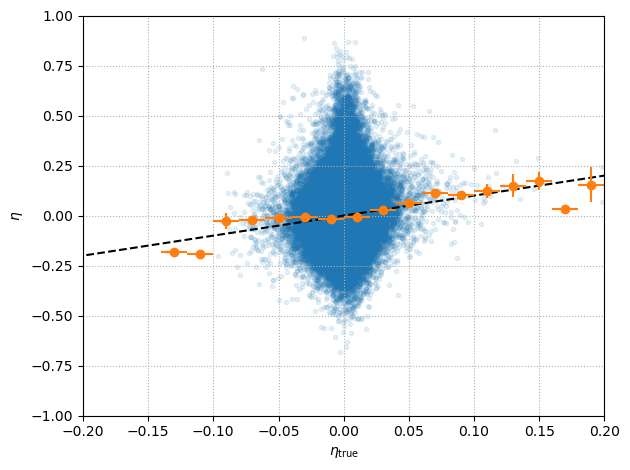

In [64]:
plt.figure(tight_layout=True)

plt.plot(eta_true[mock_main], eta_mock[mock_main], '.', alpha=0.1, zorder=0)
# plt.hexbin(eta_true, eta_mock, gridsize=1000, bins='log')

plt.plot([-5, 2], [-5, 2], 'k--')

eta_bins = np.arange(-0.5, 0.3, 0.02)
d_eta = 0.5*np.diff(eta_bins)
eta_c = 0.5*(eta_bins[1:] + eta_bins[:-1])

_, eta_avg, eta_std = profile_histogram(eta_true[mock_main], eta_mock[mock_main], eta_bins, median=True)
plt.errorbar(eta_c, eta_avg, xerr=d_eta, yerr=eta_std, fmt='o', color='tab:orange', zorder=2)

plt.grid(ls=':')

plt.xlim([-0.2, 0.2])
plt.ylim([-1, 1])

plt.xlabel(r'$\eta_\mathrm{true}$')
plt.ylabel(r'$\eta$');

/tmp/ipykernel_411141/3818747994.py:45: RuntimeWarning: invalid value encountered in true_divide
  h = H/W
/tmp/ipykernel_411141/3818747994.py:46: RuntimeWarning: divide by zero encountered in true_divide
  e = 1/np.sqrt(W)


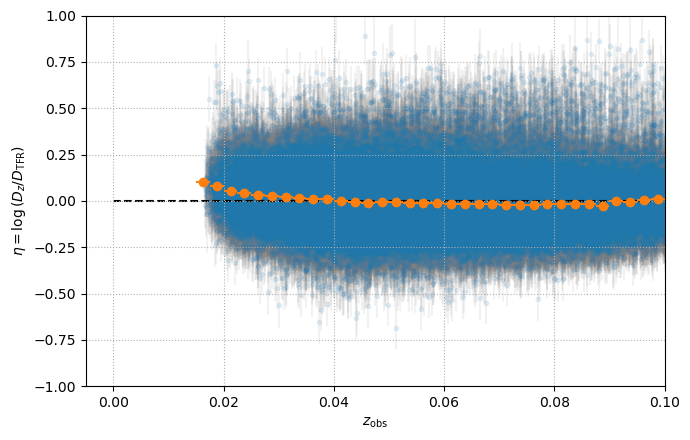

In [60]:
fig, ax = plt.subplots(1,1, figsize=(7,4.5), tight_layout=True)
ax.errorbar(mock['zobs'][mock_main], eta_mock[mock_main],
            yerr=eta_err_mock[mock_main],
            fmt='.',
            alpha=0.1,
            ecolor='gray', 
            zorder=0)

zbins = np.arange(0, 0.1025, 0.0025)
dz = 0.5*np.diff(zbins)
zc = 0.5*(zbins[1:] + zbins[:-1])

_, eta_avg, eta_std = profile_histogram(mock['zobs'][mock_main], eta_mock[mock_main], 
                                        zbins, weights=eta_err_mock[mock_main]**-2, weighted=True)
ax.errorbar(zc, eta_avg, xerr=dz, yerr=eta_std, fmt='o', color='tab:orange', zorder=2)

ax.hlines(0, zbins[0], zbins[-1], colors='k', linestyles='dashed', zorder=1)
ax.grid(ls=':')

ax.set(xlabel=r'$z_\mathrm{obs}$',
       xlim=(-0.005,0.1),
       ylim=(-1,1),
       ylabel=r'$\eta = \log{(D_z / D_\mathrm{TFR})}$');

# fig.savefig('tfr_mock_eta.png', dpi=150);

/tmp/ipykernel_411141/1790439695.py:1: RuntimeWarning: invalid value encountered in log10
  logdist_true = np.log10(cosmology.comoving_distance(mock['zobs'].to_numpy()).value/cosmology.comoving_distance(mock['zcos'].to_numpy()).value)


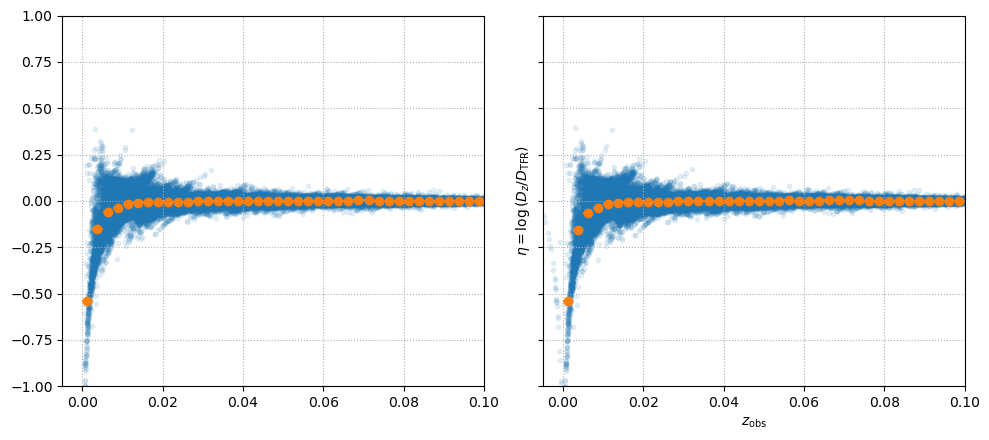

In [53]:
logdist_true = np.log10(cosmology.comoving_distance(mock['zobs'].to_numpy()).value/cosmology.comoving_distance(mock['zcos'].to_numpy()).value)

fig, axes = plt.subplots(1,2, figsize=(10,4.5), tight_layout=True, sharex=True, sharey=True)

ax = axes[0]
ax.scatter(mock['zobs'], logdist_true, marker='.', alpha=0.1)

ax = axes[1]
ax.scatter(mock['zobs'], eta_true, marker='.', alpha=0.1)

zbins = np.arange(0, 0.1025, 0.0025)
dz = 0.5*np.diff(zbins)
zc = 0.5*(zbins[1:] + zbins[:-1])

ax = axes[0]
_, eta_avg, eta_std = profile_histogram(mock['zobs'], logdist_true, zbins)
ax.errorbar(zc, eta_avg, xerr=dz, yerr=eta_std, fmt='o', color='tab:orange')
ax.grid(ls=':')

ax = axes[1]
_, eta_avg, eta_std = profile_histogram(mock['zobs'], eta_true, zbins)
ax.errorbar(zc, eta_avg, xerr=dz, yerr=eta_std, fmt='o', color='tab:orange')

ax.set(xlabel=r'$z_\mathrm{obs}$',
       xlim=(-0.005,0.1),
       ylim=(-1,1),
       ylabel=r'$\eta = \log{(D_z / D_\mathrm{TFR})}$')
ax.grid(ls=':');

/tmp/ipykernel_411141/3818747994.py:45: RuntimeWarning: invalid value encountered in true_divide
  h = H/W
/tmp/ipykernel_411141/3818747994.py:46: RuntimeWarning: divide by zero encountered in true_divide
  e = 1/np.sqrt(W)


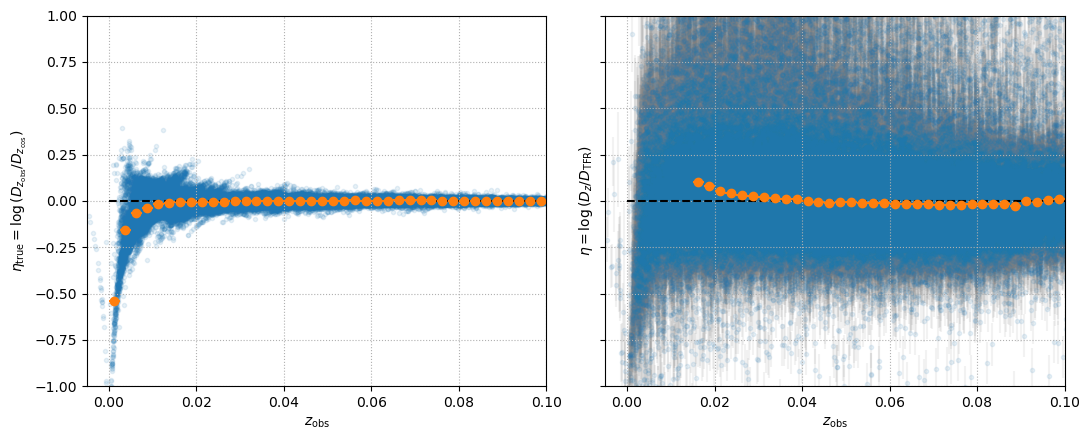

In [59]:
fig, axes = plt.subplots(1,2, figsize=(11,4.5), tight_layout=True, sharex=True, sharey=True)

ax = axes[0]
ax.plot(mock['zobs'], eta_true, '.', alpha=0.1, zorder=0)

ax = axes[1]
ax.errorbar(mock['zobs'], eta_mock, yerr=eta_err_mock, fmt='.', alpha=0.1, ecolor='gray', zorder=0)

zbins = np.arange(0, 0.1025, 0.0025)
dz = 0.5*np.diff(zbins)
zc = 0.5*(zbins[1:] + zbins[:-1])

ax = axes[0]
_, eta_avg, eta_std = profile_histogram(mock['zobs'], eta_true, zbins)
ax.errorbar(zc, eta_avg, xerr=dz, yerr=eta_std, fmt='o', color='tab:orange')
ax.hlines(0, zbins[0], zbins[-1], colors='k', linestyles='dashed')
ax.set(xlabel=r'$z_\mathrm{obs}$',
       xlim=(-0.005,0.1),
       ylim=(-1,1),
       ylabel=r'$\eta_\mathrm{true} = \log{(D_{z_\mathrm{obs}} / D_{z_\mathrm{cos}})}$')
ax.grid(ls=':')

ax = axes[1]
_, eta_avg, eta_std = profile_histogram(mock['zobs'][mock_main], eta_mock[mock_main], 
                                        zbins, weights=eta_err_mock[mock_main]**-2, weighted=True)
ax.errorbar(zc, eta_avg, xerr=dz, yerr=eta_std, fmt='o', color='tab:orange')
ax.hlines(0, zbins[0], zbins[-1], colors='k', linestyles='dashed')
ax.set(xlabel=r'$z_\mathrm{obs}$',
       xlim=(-0.005,0.1),
       ylim=(-1,1),
       ylabel=r'$\eta = \log{(D_z / D_\mathrm{TFR})}$')
ax.grid(ls=':');

# fig.savefig('tfr_mock_eta_true_mock.png', dpi=150);

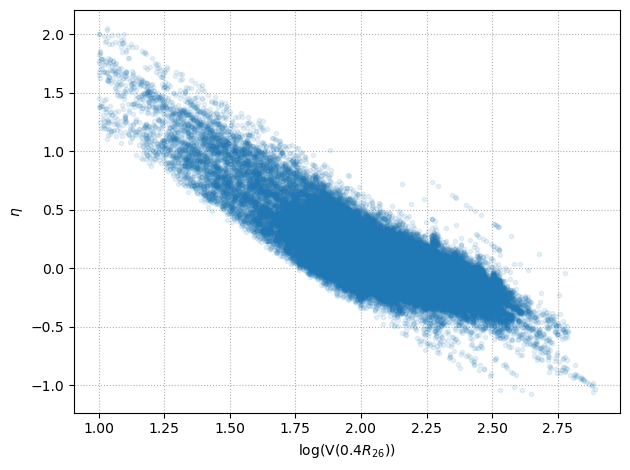

In [55]:
plt.figure(tight_layout=True)

plt.plot(logvrot_mock[~mock_dwarfs], eta_mock[~mock_dwarfs], '.', alpha=0.1)

plt.grid(ls=':')

plt.xlabel('log(V(0.4$R_{26}$))')
plt.ylabel('$\eta$');

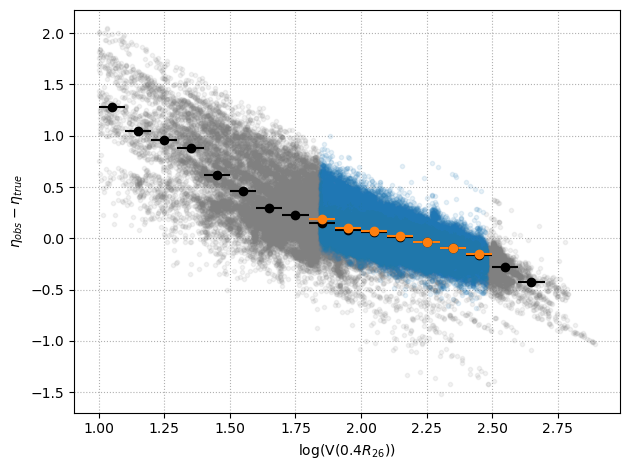

In [58]:
logv_bins = np.arange(1, 2.75, 0.1)
dv = 0.5*np.diff(logv_bins)
vc = 0.5*(logv_bins[1:] + logv_bins[:-1])

plt.figure(tight_layout=True)

plt.plot(logvrot_mock[~mock_main], 
         eta_mock[~mock_main] - eta_true[~mock_main], 
         '.', c='gray', alpha=0.1)

plt.plot(logvrot_mock[mock_main], 
         eta_mock[mock_main] - eta_true[mock_main], 
         '.', c='tab:blue', alpha=0.1)

_, dn_avg, dn_std = profile_histogram(logvrot_mock, eta_mock - eta_true, logv_bins, median=True)
plt.errorbar(vc, dn_avg, xerr=dv, yerr=dn_std, fmt='o', color='black')

_, dn_avg, dn_std = profile_histogram(logvrot_mock[mock_main], 
                                      eta_mock[mock_main] - eta_true[mock_main], 
                                      logv_bins, 
                                      median=True)
plt.errorbar(vc, dn_avg, xerr=dv, yerr=dn_std, fmt='o', color='tab:orange')

plt.grid(ls=':')

plt.xlabel('log(V(0.4$R_{26}$))')
plt.ylabel('$\eta_{obs} - \eta_{true}$');

## Write Output to FITS

In [34]:
outfile = os.path.join('/global/cfs/cdirs/desi/science/td/pv/mocks/TF_mocks/fullmocks/v0.5',
                       os.path.basename(mockfile).replace('.dat.hdf5', '.fits').replace('BGS_PV', 'TF'))

hdr = fits.Header(dict(NTF=len(mock),
                       a=a_mcmc,
                       b=b_mcmc,
                       sigma=sigma_mcmc,
                       cov_aa=cov_mcmc[0][0],
                       cov_ab=cov_mcmc[0][1],
                       cov_as=cov_mcmc[0][2],
                       cov_bb=cov_mcmc[1][1],
                       cov_bs=cov_mcmc[1][2],
                       cov_ss=cov_mcmc[2][2]))

col01 = fits.Column(name='RA',            format='D', array=mock['ra'].to_numpy())
col02 = fits.Column(name='DEC',           format='D', array=mock['dec'].to_numpy())
col03 = fits.Column(name='ZOBS',          format='D', array=mock['zobs'].to_numpy())
col04 = fits.Column(name='ZCOS',          format='D', array=mock['zcos'].to_numpy())
col05 = fits.Column(name='vx',            format='D', array=mock['vx'].to_numpy())
col06 = fits.Column(name='vy',            format='D', array=mock['vy'].to_numpy())
col07 = fits.Column(name='vz',            format='D', array=mock['vz'].to_numpy())
col08 = fits.Column(name='DWARF',         format='L', array=mock['DWARF'].to_numpy())
col09 = fits.Column(name='LOGVROT',       format='D', array=mock['LOGVROT_MOCK'].to_numpy())
col10 = fits.Column(name='R_ABSMAG_SB26', format='D', array=mock['R_ABSMAG_SB26_MOCK'].to_numpy())
col11 = fits.Column(name='LOGDIST_TRUE',  format='D', array=eta_true)
col12 = fits.Column(name='LOGDIST',       format='D', array=eta_mock.to_numpy())
col13 = fits.Column(name='LOGDIST_ERR',   format='D', array=eta_err_mock.to_numpy())

hdulist = fits.BinTableHDU.from_columns([col01, col02, col03, col04, col05,
                                         col06, col07, col08, col09, col10,
                                         col11, col12, col13], header=hdr)
hdulist.writeto(outfile, overwrite=True)

shutil.chown(outfile, group='desi')